<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# NIRSpec FS Pipeline Notebook

**Authors**: Elena Manjavacas (emanjavacas@stsci.edu), building on the work of Peter Zeidler (zeidler@stsci.edu), Kayli Glidic (kglidic@stsci.edu), and James Muzerolle (muzerol@stsci.edu); NIRSpec branch </br>
**Last Updated**: August 5, 2025 </br>
**Pipeline Version**: 1.19.1 (Build 12.0, Context jwst_1413.pmap)

**Purpose**:<br>
This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) fixed slit (FS) data through the three stages of the JWST pipeline. It includes how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. Data is assumed to be organized into two folders: science and background, as specified in the paths set up below. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options or plot parameters need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**: <br>
This notebook is set up to use observations of HD1808347 A3V standard star (point source) with the G235M grism obtained by Proposal ID (PID) 1128, Observation 6. The demo data will be automatically downloaded in the `demo_mode` unless disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**: <br>
This notebook was written for the calibration pipeline version given above and uses the context associated with this version of the JWST Calibration Pipeline. Information about this an other contexts can be found in the JWST Calibration Reference Data System (CRDS) 
[server](https://jwst-crds.stsci.edu/). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references)

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-fs-known-issues#gsc.tab=0) for this build are noted in the notebook. 

**Updates**: <br>
This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/). 

**Recent Changes**:</br>
* October 15, 2024: Converted notebook to follow standard template (kglidic@stsci.edu). <br>
* November 4, 2024: Notebook updated to JWST pipeline version 1.16.0 (Build 11.1).
* January 6, 2025: Updated formatting and added examples for creating association files.
* January 27, 2025: Notebook updated to JWST pipeline version 1.17.1 (Build 11.2) and added more association file information.
* April 16, 2025: Updated JWST pipeline version 1.18.0 (Build 11.3) and added Jdaviz plotting options.<br>
* July 16, 2025: Updated to JWST pipeline version 1.19.1 (no significant changes)

## Table of Contents

* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
        * [5.2.1 Calibrating Science Files](#5.2.1-Calibrating-Science-Files)
        * [5.2.2 Calibrating Background Files](#5.2.2-Calibrating-Background-Files)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#6.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` Association Files](#6.2-Create-Spec2Pipeline-Association-Files)
    * [6.3 Run `Spec2Pipeline`](#6.3-Run-Spec2Pipeline)
        * [6.3.1 Calibrating Science Files](#6.3.1-Calibrating-Science-Files)
        * [6.3.2 Calibrating Background Files](#6.3.2-Calibrating-Background-Files)
* [7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)](#7.-Stage-3:-Spec3Pipeline-(calwebb_spec3))
    * [7.1 Configure `Spec3Pipeline`](#7.1-Configure-Spec3Pipeline)
    * [7.2 Create `Spec3Pipeline` Association Files](#7.2-Create-Spec3Pipeline-Association-Files)
    * [7.3 Run `Spec3Pipeline`](#7.3-Run-Spec3Pipeline)
* [8. Visualize the Data](#8.-Visualize-the-Data)
    * [8.1 Display `Detector1Pipeline` Products](#8.1-Display-Detector1Pipeline-Products)
    * [8.2 Display `Spec2Pipeline` Products](#8.2-Display-Spec2Pipeline-Products)
    * [8.3 Display `Spec3Pipeline` Products](#8.3-Display-Spec3Pipeline-Products)
* [9. Modifying the EXTRACT1D Reference File (as needed)](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))
---

## 1. Configuration

### Install dependencies and parameters

To make sure that the pipeline version is compatible with the steps discussed below and that the required dependencies and packages get installed, you can create a fresh conda environment and install the provided requirements.txt file before starting this notebook:

    conda create -n nirspec_fs_pipeline python=3.12
    conda activate nirspec_fs_pipeline
    pip install -r requirements.txt

### Set the basic parameters to configure the notebook

These parameters determine what data gets used, where data is located (if already on disk), and the type of background subtraction (if any). The list of parameters includes:

* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location.<br><br>
    
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.
    * `bg_dir`: Directory where dedicated background observation data is stored.<br><br>
    
* **[Backgroud subtraction methods](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_subtraction/main.html#spectroscopic-modes:~:text=the%20calwebb_image3%20pipeline.-,Spectroscopic%20Modes,%EF%83%81,-Spectroscopic%20observations%20allow)**: <br>
    * `master_bg` = `True`: Apply master-background subtraction in `calwebb_spec3`. For dedicated background observations.
    * `pixel_bg` = `True`: Apply pixel-to-pixel background subtraction in `calwebb_spec2`.  This is the default pipeline setting. Typically uses noded observations.<br><br>

In [1]:
# Basic import necessary for configuration.
# Uncomment logging to hide log information.

import os
import warnings
#import logging

# Control logging level: INFO, WARNING, ERROR
# Run command logging.disable if want to hide logging
# ERROR messages.
#logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">
    
Note that `demo_mode` must be set appropriately below.
</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -------------------------------DEMO MODE-----------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# ----------------------------User Mode Directories--------------------------
else:  # If demo_mode = False, look for user data in these paths.

    # Set directory paths for processing specific data; adjust to your local
    # directory setup (examples provided below).
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))

    # Directory to science observation data; expects uncalibrated data in
    # sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    sci_dir = os.path.join(basedir, 'fs_data_01128/Obs006', '')

    # Directory to background observation data; expects uncalibrated data in
    # bg_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    #bg_dir = os.path.join(basedir, 'fs_data_02288/Obs002', '')
    bg_dir = ''  # If no background observation, use an empty string.

# ---------------------------Set Processing Steps----------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing.
dodet1 = True  # calwebb_detector1
dospec2 = True  # calwebb_spec2
dospec3 = True  # calwebb_spec3
doviz = True  # Visualize calwebb outputs

# Background Processing.
dodet1bg = False  # calwebb_detector1
dospec2bg = False  # calwebb_spec2 (needed for Master Background subtraction)

# How should background subtraction be done?
# Set one or None of the flags below.
# If none are selected, data will not be background subtracted.
# If background subtraction is done in Spec2 it will be skipped in Spec3.
# Note: Master-background subtraction is for dedicated background observations.
# Dedicated backgrounds must be processed through spec2 first.
master_bg = False  # Master-background subtraction in spec3.
pixel_bg = True  # Pixel-based background subtraction in spec2.

Running in demonstration mode using online example data!


---

### Set CRDS Context and Server

Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.

[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths------------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here, we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1364.pmap'  # CRDS context for 1.18.0

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/runner/crds_cache
CRDS file server: https://jwst-crds.stsci.edu



---

## 2. Package Imports


In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML, JSON
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# ----------------------General Imports----------------------
import time
import glob
import json
import itertools
import numpy as np

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# ----------------------Astroquery Import----------------------
from astroquery.mast import Observations

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from jdaviz import Specviz2d

<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found in [JWST User Documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) • 
[Github](https://github.com/spacetelescope/jwst)

</div> 

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
import jwst  # Import the base JWST and CRDS packages.
import crds
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Spec3Pipeline  # calwebb_spec3
from jwst.extract_1d import Extract1dStep  # Extract1D Step

# JWST pipeline utilities.
from jwst import datamodels  # JWST datamodels.
from jwst.associations import asn_from_list as afl  # Tools for creating ASN files.
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Lvl2 ASN file.
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Lvl3 ASN file.

default_context = crds.get_default_context('jwst', state='build')
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print(f"Default CRDS Context for JWST Version {jwst.__version__}: {default_context}")
print(f"Using CRDS Context: {os.environ.get('CRDS_CONTEXT', default_context)}")

CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.19.1.dist-info)


JWST Calibration Pipeline Version = 1.19.1
Default CRDS Context for JWST Version 1.19.1: jwst_1413.pmap
Using CRDS Context: jwst_1413.pmap


---
### Define Convenience Functions


Define a function that filters a list of files based on a specific FITS header key-value condition.

In [7]:
def filter_list(files, key, value):
    """
    Filter a list of files based on a specific FITS header key-value condition.

    Parameters
    ----------
    files : list
        List of file paths to FITS files.
    key : str
        The FITS header key to check.
    value : Any
        The value to match for the specified header key.

    Returns
    -------
    list : A list of file paths that satisfy the key-value condition.
    """
    return [file for file in files if fits.getheader(file).get(key) == value]

Define a function that filters files based on detector, filter, and grating.

In [8]:
def get_matching(files, detector, filt, grating, fxd_slit, exp_type):
    """
    Filters a list of FITS files to find those with matching 
    detector, filter, and grating for a specified exposure type.

    Parameters
    ----------
    files : list of str
        Paths to FITS files to check.
    detector : str
        Expected value of the DETECTOR keyword.
    filt : str
        Expected value of the FILTER keyword.
    grating : str
        Expected value of the GRATING keyword.
    fxd_slit : str
        Fixed slit name.
    exp_type : str, optional
        The exposure type to match.

    Returns
    -------
    files_regular : list of str
        Files with matching configuration and IS_IMPRT == False or missing.
    files_imprint : list of str)
        Files with matching configuration and IS_IMPRT == True.
    """
    files_regular, files_imprint = [], []
    for file in files:
        # Skip if EXP_TYPE doesn't match the provided one.
        if fits.getval(file, 'EXP_TYPE') != exp_type:
            files_regular.append(file)
            continue
        # Check if DETECTOR, FILTER, and GRATING match
        detector_match = fits.getval(file, 'DETECTOR') == detector
        filter_match = fits.getval(file, 'FILTER') == filt
        grating_match = fits.getval(file, 'GRATING') == grating
        slit_match = fits.getval(file, 'FXD_SLIT') == fxd_slit
        if detector_match and filter_match and grating_match and slit_match:
            # Only IFU and MOS observations have imprint exposures.
            try:
                is_imprt = fits.getval(file, 'IS_IMPRT')
            except KeyError:
                is_imprt = None
            (files_imprint if is_imprt else files_regular).append(file)
    return files_regular, files_imprint

Define a function that checks the grating wheel tilt value between two files.

In [9]:
def match_gwa(file1, file2):
    """
    Check if GWA tilt values match closely enough to be associated.
    
    Parameters
    ----------
    file1, file2 : str 
        Input exposures FITS file paths.

    Returns
    -------
    True if both GWA tilt values match within tolerance, else False.
    """
    hdr1, hdr2 = fits.getheader(file1), fits.getheader(file2)
    return np.allclose(
        (hdr1['GWA_XTIL'], hdr1['GWA_YTIL']),
        (hdr2['GWA_XTIL'], hdr2['GWA_YTIL']),
        atol=1e-8, rtol=0
    )

In [10]:
# Start a timer to keep track of runtime.
time0 = time.perf_counter()

---

## 3. Demo Mode Setup (ignore if not using demo data)

<div class="alert alert-block alert-info">

 The data in this notebook is public and does not require a token. For other data sets, you may need to provide a token. For more infomation visit [astroquery](https://astroquery.readthedocs.io/en/latest/index.html#) documentation.
    
</div> 

If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).


The FS demo data in this notebook is from the [NIRSpec calibration program 1128](https://www.stsci.edu/jwst/science-execution/program-information?id=1128) and features observations of HD1808347 (point source) using the G235M grism. The program setup is briefly summarized in the table below.


| Demo Target: HD1808347 A3V Standard Star |       |   | 
|:-----------:|:-------:|:---:|
| PROGRAM | 01128 | Program number | 
| OBSERVTN | 006 | Observation number | 
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-fixed-slits-spectroscopy#gsc.tab=0:~:text=%C2%A0Table%202.%20NIRSpec%20A%20fixed%20slit%C2%A0instrument%20configurations%2C%20resolutions%2C%20and%20wavelength%20ranges) | G235M/F170LP | λ: 1.66–3.17 μm (a medium resolution, R ~ 1000) |
| SUBARRAY | SUBS200A1 | Subarray used | 
| NINTS | 2 | Number of integrations in exposure |           
| NGROUPS | 30 | Number of groups in integration |
| DURATION | 96.637 [s] | Total duration of one exposure |   
| READPATT | NRSRAPID | Readout pattern | 
| PATTTYPE | 3-POINT-NOD | Primary dither pattern type |  
| NUMDTHPT | 3 |  Total number of points in pattern |                           
| SRCTYAPT | POINT | Source type selected in APT |

> **Note:** The presence of a physical gap between detectors affects high-resolution FS observations because the spectra are long enough to span both NIRSpec detectors. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-fs-operations/nirspec-fs-wavelength-ranges-and-gaps#gsc.tab=0)

In [11]:
# Set up the program information and directories to collect
# the data in demo_mode.
if demo_mode:
    
    print('Running in demonstration mode. '
          'Example data will be downloaded from MAST!')

    # For non public data sets, you may need to provide a token.
    # However, for security it is not recommended to enter tokens into
    # a terminal or Jupyter notebook.
    #Observations.login(token="your-token")

    # --------------Program and observation information--------------
    program = "01128"
    sci_observtn = "006"
    bg_observtn = None
    filters = ["F170LP;G235M"]

    # ----------Define the base and observation directories----------
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))
    sci_dir = os.path.join(basedir, f'fs_data_{program}')
    sci_dir = os.path.join(sci_dir, f'Obs{sci_observtn}')
    uncal_dir = os.path.join(sci_dir, 'uncal/')

    # If no background observation, leave blank.
    bg_dir = os.path.join(basedir, f'fs_data_{program}')
    bg_dir = os.path.join(bg_dir, f'Obs{bg_observtn}') if bg_observtn else ''
    uncal_bgdir = os.path.join(bg_dir, 'uncal/') if bg_observtn else ''

    # ------Ensure directories for downloading MAST data exists------
    os.makedirs(uncal_dir, exist_ok=True)
    # Makes directory only when a background observation is provided.
    if bg_observtn:
        os.makedirs(uncal_bgdir, exist_ok=True)
else:
    print('Running with user provided data.')

Running in demonstration mode. Example data will be downloaded from MAST!


<br>Click on the following links to learn more about querying and downloading data:<br>
• [Downloading data](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data)<br>
• [Observations Class](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html)<br>
• [Products Field Descriptions](https://mast.stsci.edu/api/v0/_productsfields.html)<br><br>

Compile tables of files from MAST associated with the science (SCI) and, if applicable, background (BG) observations. Note that the demo data does not have BG observations.

In [12]:
# Obtain a list of observation IDs for the specified demo program.
if demo_mode:
    
    # --------------------SCIENCE Observation--------------------
    sci_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/SLIT'],
                                                   provenance_name=["CALJWST"],
                                                   obs_id=[f'*{program}*{sci_observtn}*'])

    if bg_dir:
        # ------------------BACKGROUND Observation-------------------
        bg_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/SLIT'],
                                                      provenance_name=["CALJWST"],
                                                      obs_id=[f'*{program}*{bg_observtn}*'])



The demo dataset consists of six `_uncal.fits` files, each approximately 15 MB in size.

In [13]:
# Convert visits into a list of uncalibrated data and ASN files.
if demo_mode:
    
    file_criteria = {'filters': filters, 'calib_level': [1],
                     'productSubGroupDescription': 'UNCAL'}

    # Initialize lists for science and background files.
    sci_downloads, bg_downloads = [], []

    pfilter = Observations.filter_products  # Alias for filter_products method.

    # ----------Identify uncalibrated SCIENCE files associated with each visit----------
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)

        # Filter for full-size science files (exclude smaller confirmation images).
        avg_sci_size = np.nanmean(sci_products['size'])
        sci_products = sci_products[sci_products['size'] > avg_sci_size]
        sci_downloads.extend(pfilter(sci_products, **file_criteria)['dataURI'])

    # --------Identify uncalibrated BACKGROUND files associated with each visit---------
    if bg_dir:
        for exposure in bg_obs_id_table:
            bg_products = Observations.get_product_list(exposure)

            # Filter for full-size background files (exclude smaller confirmation images).
            avg_bg_size = np.nanmean(bg_products['size'])
            bg_products = sci_products[bg_products['size'] > avg_bg_size]
            bg_downloads.extend(pfilter(bg_products, **file_criteria)['dataURI'])

    # Filter out other observations and remove duplicates.
    sci_downloads = {f for f in sci_downloads if f"jw{program}{sci_observtn}" in f}
    print(f"Science files selected for downloading: {len(sci_downloads)}")

    if bg_dir:
        bg_downloads = {f for f in bg_downloads if f"jw{program}{bg_observtn}" in f}
        print(f"Background files selected for downloading: {len(bg_downloads)}")
    else:
        print("Background files selected for downloading: 0")

Science files selected for downloading: 6
Background files selected for downloading: 0


Download the data.
<div class="alert alert-block alert-warning">

**Warning**: If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

In [14]:
# Download data and place them into the appropriate directories.
if demo_mode:
    for file in sci_downloads:
        sci_manifest = Observations.download_file(file, local_path=uncal_dir)
    for file in bg_downloads:
        bg_manifest = Observations.download_file(file, local_path=uncal_bgdir)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


---

## 4. Directory Setup
Set up detailed paths to input/output stages here.

In [15]:
# Define/create output subdirectories to keep data products organized.

# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
asn_dir = os.path.join(sci_dir, 'asn/')  # Association files.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
spec3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_spec3 pipeline outputs.

# Creates the directories if target directory does not exist.
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(asn_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(spec3_dir, exist_ok=True)

# ---------------------------Background Directories-----------------------------
if bg_dir:
    uncal_bgdir = os.path.join(bg_dir, 'uncal/')  # Uncalibrated pipeline inputs.
    asn_bgdir = os.path.join(bg_dir, 'asn/')  # Association files.
    det1_bgdir = os.path.join(bg_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
    spec2_bgdir = os.path.join(bg_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.

    # Creates directories if background observations are provided and do not already exist.
    os.makedirs(det1_bgdir, exist_ok=True)
    os.makedirs(asn_bgdir, exist_ok=True)
    os.makedirs(spec2_bgdir, exist_ok=True)

In [16]:
# Print out the time benchmark.
time1 = time.perf_counter()
print(f"Runtime so far: {round((time1-time0)/60.0, 1):0.4f} min")

Runtime so far: 0.2000 min


---

## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)

In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing. 

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec FS:

> * `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
> * `dq_init` : Initializes the data quality (DQ) flags for the input data.
> * `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
> * `superbias` : Subtracts the superbias reference file from the input data.
> * `refpix` : Use reference pixels to correct bias drifts.
> * `linearity` : Applies a correction for non-linear detector response.   
> * `dark_current` : Subtracts the dark current reference file from the input data.
> * `jump` : Performs CR/jump detection on each ramp integration within an exposure.
> * `clean_flicker_noise`: Removes flicker (1/f) noise from calibrated ramp images (similar to `nsclean` in spec2).
> * `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
> * `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for FS data. 

<div class="alert alert-warning">
  To override specific steps and reference files, use the examples below.
</div>


In [17]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'] = {}, {}
det1dict['linearity'], det1dict['dark_current'], det1dict['jump'] = {}, {}, {}
det1dict['clean_flicker_noise'], det1dict['ramp_fit'] = {}, {}
det1dict['gain_scale'] = {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#det1dict['dq_init']['override_mask'] = 'myfile.fits'  # Bad pixel mask
#det1dict['superbias']['override_superbias'] = 'myfile.fits'  # Bias subtraction
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
#det1dict['linearity']['skip'] = True  # This is the default.

# Suppress computations for saturated ramps with
# only one good (unsaturated) sample (default True).
# The demo data has some saturation.
det1dict['ramp_fit']['suppress_one_group'] = False

# Turn on multi-core processing (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'half'

<div class="alert alert-info">

The `refpix_algorithm` parameter in the `refpix` step is applicable only to NIR data. For NIRSpec full-frame data using traditional readout modes (NRS, NRSRAPID), the default algorithm—set in the parameter reference file as of Build 12.0—is 'sirs' (Simple Improved Reference Subtraction), which uses reference pixels from the left and right sides. For subarray data or non-traditional readouts, the algorithm automatically defaults to 'median'.

</div>

In [18]:
#det1dict['refpix']['refpix_algorithm'] = 'sirs'  # default

<div class="alert alert-info">
    
Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.
</div>

In [19]:
# Turn on detection of cosmic ray snowballs (on by default).
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['expand_factor'] = 3  # (default 2)

<div class="alert alert-info">

JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This noise manifests as faint banding along the detector's slow axis and varies from column to column. For NIRSpec data, the primary pipeline algorithm to address 1/f noise is `nsclean` in the `Spec2Pipeline` (Rauscher 2023) but is off by default.

An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default.
</div>

In [20]:
# Turn on 1/f noise correction in Stage 1? (off by default).
#det1dict['clean_flicker_noise']['skip'] = False
#det1dict['clean_flicker_noise']['fit_method'] = 'fft'
#det1dict['clean_flicker_noise']['background_method'] = None
#det1dict['clean_flicker_noise']['mask_science_regions'] = False
#det1dict['clean_flicker_noise']['n_sigma'] = False

---

### 5.2 Run `Detector1Pipeline`

Run the science files, nods, and, if available, any dedicated background files through the `calwebb_detector1` pipeline using the `.call()` method. 

We use `.call()` instead of `.run()` to ensure that the latest default parameters defined via reference files in CRDS, are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).

This stage takes approximately 2 minutes to process six `_uncal.fits` files from the demo data.

In [21]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))
print(f"Science UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_sci))

if bg_dir:
    uncal_bg = sorted(glob.glob(uncal_bgdir + '*uncal.fits'))
    print(f"Background UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_bg))

Science UNCAL Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00001_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00001_nrs2_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00002_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00002_nrs2_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00003_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00003_nrs2_uncal.fits


In [22]:
time_det1 = time.perf_counter()  # Tracks runtime for Stage 1.

---

#### 5.2.1 Calibrating Science Files
Identify the input science files and execute the `calwebb_detector1` pipeline using the `call` method.

In [23]:
# Run Stage 1 pipeline on the science using the custom det1dict dictionary.
if dodet1:

    #--------------------------Science UNCAL files--------------------------
    for uncal_file in uncal_sci:

        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1_result = Detector1Pipeline.call(uncal_file,
                                             save_results=True,
                                             steps=det1dict,
                                             output_dir=det1_dir)
    print("Detector1 has been completed for SCI data! \n")
else:
    print('Skipping Detector1 processing for SCI data.')

Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00001_nrs1_uncal.fits


2025-11-10 19:26:32,408 - CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.19.1.dist-info)


2025-11-10 19:26:32,819 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 206 files) (0 / 754.6 K bytes)


2025-11-10 19:26:32,914 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_calver_0054.rmap    5.5 K bytes  (2 / 206 files) (694 / 754.6 K bytes)


2025-11-10 19:26:33,009 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_0053.imap      385 bytes  (3 / 206 files) (6.2 K / 754.6 K bytes)


2025-11-10 19:26:33,089 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 206 files) (6.6 K / 754.6 K bytes)


2025-11-10 19:26:33,150 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 206 files) (8.0 K / 754.6 K bytes)


2025-11-10 19:26:33,245 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_superbias_0081.rmap   36.1 K bytes  (6 / 206 files) (8.8 K / 754.6 K bytes)


2025-11-10 19:26:33,311 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_sirskernel_0002.rmap      704 bytes  (7 / 206 files) (44.9 K / 754.6 K bytes)


2025-11-10 19:26:33,382 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_sflat_0027.rmap   20.6 K bytes  (8 / 206 files) (45.6 K / 754.6 K bytes)


2025-11-10 19:26:33,450 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 206 files) (66.2 K / 754.6 K bytes)


2025-11-10 19:26:33,601 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 206 files) (68.2 K / 754.6 K bytes)


2025-11-10 19:26:33,692 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 206 files) (69.8 K / 754.6 K bytes)


2025-11-10 19:26:33,772 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 206 files) (72.4 K / 754.6 K bytes)


2025-11-10 19:26:33,825 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 206 files) (73.1 K / 754.6 K bytes)


2025-11-10 19:26:33,889 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 206 files) (74.0 K / 754.6 K bytes)


2025-11-10 19:26:33,941 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 206 files) (75.2 K / 754.6 K bytes)


2025-11-10 19:26:33,998 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 206 files) (76.0 K / 754.6 K bytes)


2025-11-10 19:26:34,051 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 206 files) (78.1 K / 754.6 K bytes)


2025-11-10 19:26:34,108 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-refpixstep_0002.rmap      831 bytes  (18 / 206 files) (78.8 K / 754.6 K bytes)


2025-11-10 19:26:34,199 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (19 / 206 files) (79.6 K / 754.6 K bytes)


2025-11-10 19:26:34,257 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (20 / 206 files) (80.8 K / 754.6 K bytes)


2025-11-10 19:26:34,322 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (21 / 206 files) (81.6 K / 754.6 K bytes)


2025-11-10 19:26:34,381 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (22 / 206 files) (82.6 K / 754.6 K bytes)


2025-11-10 19:26:34,442 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (23 / 206 files) (83.7 K / 754.6 K bytes)


2025-11-10 19:26:34,567 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (24 / 206 files) (84.5 K / 754.6 K bytes)


2025-11-10 19:26:34,623 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (25 / 206 files) (86.3 K / 754.6 K bytes)


2025-11-10 19:26:34,675 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (26 / 206 files) (87.6 K / 754.6 K bytes)


2025-11-10 19:26:34,730 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (27 / 206 files) (89.1 K / 754.6 K bytes)


2025-11-10 19:26:34,790 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (28 / 206 files) (90.4 K / 754.6 K bytes)


2025-11-10 19:26:34,842 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (29 / 206 files) (93.9 K / 754.6 K bytes)


2025-11-10 19:26:34,922 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (30 / 206 files) (95.5 K / 754.6 K bytes)


2025-11-10 19:26:34,977 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (31 / 206 files) (96.4 K / 754.6 K bytes)


2025-11-10 19:26:35,039 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (32 / 206 files) (97.9 K / 754.6 K bytes)


2025-11-10 19:26:35,092 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (33 / 206 files) (99.4 K / 754.6 K bytes)


2025-11-10 19:26:35,149 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (34 / 206 files) (100.9 K / 754.6 K bytes)


2025-11-10 19:26:35,217 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (35 / 206 files) (102.7 K / 754.6 K bytes)


2025-11-10 19:26:35,313 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (36 / 206 files) (103.9 K / 754.6 K bytes)


2025-11-10 19:26:35,373 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (37 / 206 files) (108.9 K / 754.6 K bytes)


2025-11-10 19:26:35,429 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fflat_0027.rmap    7.2 K bytes  (38 / 206 files) (112.7 K / 754.6 K bytes)


2025-11-10 19:26:35,505 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (39 / 206 files) (119.9 K / 754.6 K bytes)


2025-11-10 19:26:35,564 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (40 / 206 files) (122.2 K / 754.6 K bytes)


2025-11-10 19:26:35,619 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (41 / 206 files) (127.9 K / 754.6 K bytes)


2025-11-10 19:26:35,672 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dark_0076.rmap   34.3 K bytes  (42 / 206 files) (129.0 K / 754.6 K bytes)


2025-11-10 19:26:35,743 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (43 / 206 files) (163.4 K / 754.6 K bytes)


2025-11-10 19:26:35,806 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (44 / 206 files) (164.3 K / 754.6 K bytes)


2025-11-10 19:26:35,866 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (45 / 206 files) (165.7 K / 754.6 K bytes)


2025-11-10 19:26:35,928 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (46 / 206 files) (166.9 K / 754.6 K bytes)


2025-11-10 19:26:35,991 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (47 / 206 files) (168.7 K / 754.6 K bytes)


2025-11-10 19:26:36,047 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (48 / 206 files) (175.0 K / 754.6 K bytes)


2025-11-10 19:26:36,100 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_0406.imap    5.8 K bytes  (49 / 206 files) (180.6 K / 754.6 K bytes)


2025-11-10 19:26:36,158 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0011.rmap    3.1 K bytes  (50 / 206 files) (186.4 K / 754.6 K bytes)


2025-11-10 19:26:36,220 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0008.rmap      897 bytes  (51 / 206 files) (189.5 K / 754.6 K bytes)


2025-11-10 19:26:36,275 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (52 / 206 files) (190.4 K / 754.6 K bytes)


2025-11-10 19:26:36,327 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (53 / 206 files) (191.2 K / 754.6 K bytes)


2025-11-10 19:26:36,379 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (54 / 206 files) (191.9 K / 754.6 K bytes)


2025-11-10 19:26:36,434 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_superbias_0031.rmap    7.7 K bytes  (55 / 206 files) (193.1 K / 754.6 K bytes)


2025-11-10 19:26:36,493 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specwcs_0015.rmap    3.1 K bytes  (56 / 206 files) (200.8 K / 754.6 K bytes)


2025-11-10 19:26:36,555 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (57 / 206 files) (203.9 K / 754.6 K bytes)


2025-11-10 19:26:36,606 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (58 / 206 files) (206.3 K / 754.6 K bytes)


2025-11-10 19:26:36,662 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_sirskernel_0002.rmap      700 bytes  (59 / 206 files) (207.4 K / 754.6 K bytes)


2025-11-10 19:26:36,716 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (60 / 206 files) (208.1 K / 754.6 K bytes)


2025-11-10 19:26:36,768 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (61 / 206 files) (208.9 K / 754.6 K bytes)


2025-11-10 19:26:36,824 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (62 / 206 files) (209.9 K / 754.6 K bytes)


2025-11-10 19:26:36,882 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (63 / 206 files) (211.1 K / 754.6 K bytes)


2025-11-10 19:26:36,952 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (64 / 206 files) (211.8 K / 754.6 K bytes)


2025-11-10 19:26:37,005 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (65 / 206 files) (212.6 K / 754.6 K bytes)


2025-11-10 19:26:37,109 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (66 / 206 files) (213.4 K / 754.6 K bytes)


2025-11-10 19:26:37,163 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (67 / 206 files) (214.3 K / 754.6 K bytes)


2025-11-10 19:26:37,219 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-spec2pipeline_0009.rmap    1.2 K bytes  (68 / 206 files) (217.4 K / 754.6 K bytes)


2025-11-10 19:26:37,271 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (69 / 206 files) (218.6 K / 754.6 K bytes)


2025-11-10 19:26:37,323 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (70 / 206 files) (221.0 K / 754.6 K bytes)


2025-11-10 19:26:37,375 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (71 / 206 files) (221.6 K / 754.6 K bytes)


2025-11-10 19:26:37,426 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (72 / 206 files) (224.3 K / 754.6 K bytes)


2025-11-10 19:26:37,480 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (73 / 206 files) (230.7 K / 754.6 K bytes)


2025-11-10 19:26:37,534 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (74 / 206 files) (231.7 K / 754.6 K bytes)


2025-11-10 19:26:37,589 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (75 / 206 files) (232.7 K / 754.6 K bytes)


2025-11-10 19:26:37,641 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (76 / 206 files) (233.6 K / 754.6 K bytes)


2025-11-10 19:26:37,698 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0005.rmap    5.7 K bytes  (77 / 206 files) (234.2 K / 754.6 K bytes)


2025-11-10 19:26:37,751 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (78 / 206 files) (239.9 K / 754.6 K bytes)


2025-11-10 19:26:37,802 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_mask_0023.rmap    1.4 K bytes  (79 / 206 files) (240.5 K / 754.6 K bytes)


2025-11-10 19:26:37,885 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (80 / 206 files) (241.9 K / 754.6 K bytes)


2025-11-10 19:26:37,939 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (81 / 206 files) (242.9 K / 754.6 K bytes)


2025-11-10 19:26:37,994 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (82 / 206 files) (243.5 K / 754.6 K bytes)


2025-11-10 19:26:38,047 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (83 / 206 files) (244.3 K / 754.6 K bytes)


2025-11-10 19:26:38,101 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (84 / 206 files) (250.2 K / 754.6 K bytes)


2025-11-10 19:26:38,156 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (85 / 206 files) (251.1 K / 754.6 K bytes)


2025-11-10 19:26:38,218 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (86 / 206 files) (252.0 K / 754.6 K bytes)


2025-11-10 19:26:38,274 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (87 / 206 files) (252.5 K / 754.6 K bytes)


2025-11-10 19:26:38,325 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_dark_0035.rmap    7.8 K bytes  (88 / 206 files) (255.9 K / 754.6 K bytes)


2025-11-10 19:26:38,489 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_bkg_0005.rmap    3.1 K bytes  (89 / 206 files) (263.7 K / 754.6 K bytes)


2025-11-10 19:26:38,545 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (90 / 206 files) (266.8 K / 754.6 K bytes)


2025-11-10 19:26:38,601 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (91 / 206 files) (269.5 K / 754.6 K bytes)


2025-11-10 19:26:38,655 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (92 / 206 files) (273.8 K / 754.6 K bytes)


2025-11-10 19:26:38,710 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_0283.imap    5.8 K bytes  (93 / 206 files) (275.1 K / 754.6 K bytes)


2025-11-10 19:26:38,763 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (94 / 206 files) (280.9 K / 754.6 K bytes)


2025-11-10 19:26:38,820 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0011.rmap      996 bytes  (95 / 206 files) (288.1 K / 754.6 K bytes)


2025-11-10 19:26:38,872 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (96 / 206 files) (289.1 K / 754.6 K bytes)


2025-11-10 19:26:38,926 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (97 / 206 files) (290.0 K / 754.6 K bytes)


2025-11-10 19:26:38,979 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (98 / 206 files) (291.6 K / 754.6 K bytes)


2025-11-10 19:26:39,034 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_superbias_0020.rmap   19.6 K bytes  (99 / 206 files) (293.2 K / 754.6 K bytes)


2025-11-10 19:26:39,105 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_specwcs_0024.rmap    8.0 K bytes  (100 / 206 files) (312.8 K / 754.6 K bytes)


2025-11-10 19:26:39,158 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_sirskernel_0003.rmap      671 bytes  (101 / 206 files) (320.8 K / 754.6 K bytes)


2025-11-10 19:26:39,209 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (102 / 206 files) (321.5 K / 754.6 K bytes)


2025-11-10 19:26:39,259 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_readnoise_0027.rmap   26.6 K bytes  (103 / 206 files) (324.3 K / 754.6 K bytes)


2025-11-10 19:26:39,323 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (104 / 206 files) (350.9 K / 754.6 K bytes)


2025-11-10 19:26:39,393 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (105 / 206 files) (379.2 K / 754.6 K bytes)


2025-11-10 19:26:39,450 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (106 / 206 files) (382.6 K / 754.6 K bytes)


2025-11-10 19:26:39,507 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (107 / 206 files) (384.2 K / 754.6 K bytes)


2025-11-10 19:26:39,559 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (108 / 206 files) (386.2 K / 754.6 K bytes)


2025-11-10 19:26:39,622 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-spec2pipeline_0009.rmap      984 bytes  (109 / 206 files) (390.6 K / 754.6 K bytes)


2025-11-10 19:26:39,678 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (110 / 206 files) (391.6 K / 754.6 K bytes)


2025-11-10 19:26:39,730 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (111 / 206 files) (396.3 K / 754.6 K bytes)


2025-11-10 19:26:39,781 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (112 / 206 files) (397.0 K / 754.6 K bytes)


2025-11-10 19:26:39,837 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (113 / 206 files) (397.9 K / 754.6 K bytes)


2025-11-10 19:26:39,890 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (114 / 206 files) (398.7 K / 754.6 K bytes)


2025-11-10 19:26:44,950 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-detector1pipeline_0006.rmap    1.7 K bytes  (115 / 206 files) (399.8 K / 754.6 K bytes)


2025-11-10 19:26:45,001 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (116 / 206 files) (401.6 K / 754.6 K bytes)


2025-11-10 19:26:45,054 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (117 / 206 files) (402.4 K / 754.6 K bytes)


2025-11-10 19:26:45,110 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (118 / 206 files) (403.1 K / 754.6 K bytes)


2025-11-10 19:26:45,167 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (119 / 206 files) (407.2 K / 754.6 K bytes)


2025-11-10 19:26:45,223 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (120 / 206 files) (409.6 K / 754.6 K bytes)


2025-11-10 19:26:45,280 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (121 / 206 files) (411.6 K / 754.6 K bytes)


2025-11-10 19:26:45,339 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (122 / 206 files) (413.7 K / 754.6 K bytes)


2025-11-10 19:26:45,416 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (123 / 206 files) (465.4 K / 754.6 K bytes)


2025-11-10 19:26:45,469 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (124 / 206 files) (466.8 K / 754.6 K bytes)


2025-11-10 19:26:45,521 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (125 / 206 files) (468.0 K / 754.6 K bytes)


2025-11-10 19:26:45,572 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (126 / 206 files) (468.5 K / 754.6 K bytes)


2025-11-10 19:26:45,656 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_dark_0049.rmap   29.6 K bytes  (127 / 206 files) (521.9 K / 754.6 K bytes)


2025-11-10 19:26:45,721 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_bkg_0002.rmap    7.0 K bytes  (128 / 206 files) (551.5 K / 754.6 K bytes)


2025-11-10 19:26:45,773 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (129 / 206 files) (558.4 K / 754.6 K bytes)


2025-11-10 19:26:45,847 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (130 / 206 files) (591.9 K / 754.6 K bytes)


2025-11-10 19:26:45,903 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (131 / 206 files) (596.2 K / 754.6 K bytes)


2025-11-10 19:26:45,961 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_0326.imap    5.6 K bytes  (132 / 206 files) (597.5 K / 754.6 K bytes)


2025-11-10 19:26:46,022 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (133 / 206 files) (603.1 K / 754.6 K bytes)


2025-11-10 19:26:46,084 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (134 / 206 files) (604.1 K / 754.6 K bytes)


2025-11-10 19:26:46,141 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (135 / 206 files) (604.9 K / 754.6 K bytes)


2025-11-10 19:26:46,195 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_specwcs_0044.rmap    5.9 K bytes  (136 / 206 files) (605.9 K / 754.6 K bytes)


2025-11-10 19:26:46,247 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (137 / 206 files) (611.8 K / 754.6 K bytes)


2025-11-10 19:26:46,300 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (138 / 206 files) (613.0 K / 754.6 K bytes)


2025-11-10 19:26:46,350 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (139 / 206 files) (614.0 K / 754.6 K bytes)


2025-11-10 19:26:46,413 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (140 / 206 files) (614.8 K / 754.6 K bytes)


2025-11-10 19:26:46,465 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_regions_0035.rmap    4.4 K bytes  (141 / 206 files) (618.7 K / 754.6 K bytes)


2025-11-10 19:26:46,521 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (142 / 206 files) (623.0 K / 754.6 K bytes)


2025-11-10 19:26:46,575 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (143 / 206 files) (624.7 K / 754.6 K bytes)


2025-11-10 19:26:46,633 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psf_0007.rmap    2.5 K bytes  (144 / 206 files) (626.8 K / 754.6 K bytes)


2025-11-10 19:26:46,689 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_photom_0057.rmap    3.7 K bytes  (145 / 206 files) (629.3 K / 754.6 K bytes)


2025-11-10 19:26:46,744 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (146 / 206 files) (633.0 K / 754.6 K bytes)


2025-11-10 19:26:46,817 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (147 / 206 files) (633.9 K / 754.6 K bytes)


2025-11-10 19:26:46,870 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (148 / 206 files) (634.8 K / 754.6 K bytes)


2025-11-10 19:26:46,930 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec3pipeline_0010.rmap      886 bytes  (149 / 206 files) (636.7 K / 754.6 K bytes)


2025-11-10 19:26:46,983 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec2pipeline_0013.rmap    1.4 K bytes  (150 / 206 files) (637.5 K / 754.6 K bytes)


2025-11-10 19:26:47,038 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (151 / 206 files) (639.0 K / 754.6 K bytes)


2025-11-10 19:26:47,095 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (152 / 206 files) (640.9 K / 754.6 K bytes)


2025-11-10 19:26:47,150 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (153 / 206 files) (641.5 K / 754.6 K bytes)


2025-11-10 19:26:47,202 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (154 / 206 files) (642.2 K / 754.6 K bytes)


2025-11-10 19:26:47,261 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (155 / 206 files) (645.6 K / 754.6 K bytes)


2025-11-10 19:26:47,316 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (156 / 206 files) (647.2 K / 754.6 K bytes)


2025-11-10 19:26:47,367 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (157 / 206 files) (648.3 K / 754.6 K bytes)


2025-11-10 19:26:47,427 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (158 / 206 files) (649.1 K / 754.6 K bytes)


2025-11-10 19:26:47,483 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (159 / 206 files) (649.9 K / 754.6 K bytes)


2025-11-10 19:26:47,540 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (160 / 206 files) (651.5 K / 754.6 K bytes)


2025-11-10 19:26:47,593 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (161 / 206 files) (652.3 K / 754.6 K bytes)


2025-11-10 19:26:47,645 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (162 / 206 files) (653.0 K / 754.6 K bytes)


2025-11-10 19:26:47,696 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (163 / 206 files) (655.2 K / 754.6 K bytes)


2025-11-10 19:26:47,747 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mask_0028.rmap    4.6 K bytes  (164 / 206 files) (657.1 K / 754.6 K bytes)


2025-11-10 19:26:47,799 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (165 / 206 files) (661.8 K / 754.6 K bytes)


2025-11-10 19:26:47,852 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (166 / 206 files) (664.6 K / 754.6 K bytes)


2025-11-10 19:26:47,903 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (167 / 206 files) (665.3 K / 754.6 K bytes)


2025-11-10 19:26:47,958 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (168 / 206 files) (669.2 K / 754.6 K bytes)


2025-11-10 19:26:48,012 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (169 / 206 files) (670.7 K / 754.6 K bytes)


2025-11-10 19:26:48,072 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_flat_0067.rmap   15.7 K bytes  (170 / 206 files) (674.6 K / 754.6 K bytes)


2025-11-10 19:26:48,135 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_filteroffset_0026.rmap    2.1 K bytes  (171 / 206 files) (690.2 K / 754.6 K bytes)


2025-11-10 19:26:48,186 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (172 / 206 files) (692.3 K / 754.6 K bytes)


2025-11-10 19:26:48,237 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_emicorr_0004.rmap      663 bytes  (173 / 206 files) (693.7 K / 754.6 K bytes)


2025-11-10 19:26:48,290 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (174 / 206 files) (694.4 K / 754.6 K bytes)


2025-11-10 19:26:48,348 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_distortion_0041.rmap    4.8 K bytes  (175 / 206 files) (694.9 K / 754.6 K bytes)


2025-11-10 19:26:48,403 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_dark_0037.rmap    4.4 K bytes  (176 / 206 files) (699.6 K / 754.6 K bytes)


2025-11-10 19:26:48,455 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (177 / 206 files) (704.0 K / 754.6 K bytes)


2025-11-10 19:26:48,514 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (178 / 206 files) (704.8 K / 754.6 K bytes)


2025-11-10 19:26:48,567 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_apcorr_0020.rmap    5.0 K bytes  (179 / 206 files) (705.7 K / 754.6 K bytes)


2025-11-10 19:26:48,627 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (180 / 206 files) (710.6 K / 754.6 K bytes)


2025-11-10 19:26:48,687 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_0449.imap    5.8 K bytes  (181 / 206 files) (711.9 K / 754.6 K bytes)


2025-11-10 19:26:48,745 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (182 / 206 files) (717.7 K / 754.6 K bytes)


2025-11-10 19:26:48,802 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (183 / 206 files) (718.6 K / 754.6 K bytes)


2025-11-10 19:26:48,859 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (184 / 206 files) (719.6 K / 754.6 K bytes)


2025-11-10 19:26:48,919 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (185 / 206 files) (723.4 K / 754.6 K bytes)


2025-11-10 19:26:48,976 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (186 / 206 files) (724.1 K / 754.6 K bytes)


2025-11-10 19:26:49,029 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (187 / 206 files) (725.4 K / 754.6 K bytes)


2025-11-10 19:26:49,091 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (188 / 206 files) (726.5 K / 754.6 K bytes)


2025-11-10 19:26:49,147 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (189 / 206 files) (727.4 K / 754.6 K bytes)


2025-11-10 19:26:49,204 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (190 / 206 files) (728.2 K / 754.6 K bytes)


2025-11-10 19:26:49,271 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (191 / 206 files) (728.9 K / 754.6 K bytes)


2025-11-10 19:26:49,324 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (192 / 206 files) (729.5 K / 754.6 K bytes)


2025-11-10 19:26:49,382 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (193 / 206 files) (730.5 K / 754.6 K bytes)


2025-11-10 19:26:49,436 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (194 / 206 files) (731.5 K / 754.6 K bytes)


2025-11-10 19:26:49,498 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (195 / 206 files) (732.4 K / 754.6 K bytes)


2025-11-10 19:26:49,552 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (196 / 206 files) (733.5 K / 754.6 K bytes)


2025-11-10 19:26:49,606 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap      614 bytes  (197 / 206 files) (734.4 K / 754.6 K bytes)


2025-11-10 19:26:49,658 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (198 / 206 files) (735.0 K / 754.6 K bytes)


2025-11-10 19:26:49,708 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (199 / 206 files) (735.9 K / 754.6 K bytes)


2025-11-10 19:26:49,766 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (200 / 206 files) (737.0 K / 754.6 K bytes)


2025-11-10 19:26:49,822 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (201 / 206 files) (738.2 K / 754.6 K bytes)


2025-11-10 19:26:49,875 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (202 / 206 files) (742.5 K / 754.6 K bytes)


2025-11-10 19:26:49,927 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (203 / 206 files) (743.7 K / 754.6 K bytes)


2025-11-10 19:26:49,987 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (204 / 206 files) (747.7 K / 754.6 K bytes)


2025-11-10 19:26:50,042 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_0123.imap    5.1 K bytes  (205 / 206 files) (748.9 K / 754.6 K bytes)


2025-11-10 19:26:50,098 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_1413.pmap         580 bytes  (206 / 206 files) (754.0 K / 754.6 K bytes)


2025-11-10 19:26:50,751 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUBS200A1' is not in ['FULL']


2025-11-10 19:26:50,760 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-11-10 19:26:50,812 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-11-10 19:26:50,826 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf    1.2 K bytes  (1 / 1 files) (0 / 1.2 K bytes)


2025-11-10 19:26:50,892 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-11-10 19:26:50,908 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:26:50,909 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:26:50,910 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:26:50,910 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:26:50,911 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:26:50,912 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:26:50,913 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:26:50,914 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:26:50,915 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:26:50,915 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:26:50,916 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:26:50,917 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:26:50,918 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:26:50,919 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:26:50,920 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:26:50,921 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:26:50,923 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:26:50,924 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:26:50,925 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:26:50,926 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:26:51,129 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00001_nrs1_uncal.fits',).


2025-11-10 19:26:51,149 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False


2025-11-10 19:26:51,168 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00001_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:26:51,171 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0379.fits  192.5 M bytes  (1 / 8 files) (0 / 238.7 M bytes)


2025-11-10 19:26:54,344 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits    2.1 M bytes  (2 / 8 files) (192.5 M / 238.7 M bytes)


2025-11-10 19:26:54,491 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits   14.9 M bytes  (3 / 8 files) (194.6 M / 238.7 M bytes)


2025-11-10 19:26:54,817 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits   16.8 M bytes  (4 / 8 files) (209.5 M / 238.7 M bytes)


2025-11-10 19:26:55,233 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits    4.2 M bytes  (5 / 8 files) (226.3 M / 238.7 M bytes)


2025-11-10 19:26:55,420 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits    6.4 M bytes  (6 / 8 files) (230.5 M / 238.7 M bytes)


2025-11-10 19:26:55,599 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf  133.4 K bytes  (7 / 8 files) (236.9 M / 238.7 M bytes)


2025-11-10 19:26:55,690 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits    1.6 M bytes  (8 / 8 files) (237.1 M / 238.7 M bytes)


2025-11-10 19:26:55,838 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0379.fits'.


2025-11-10 19:26:55,839 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits'.


2025-11-10 19:26:55,839 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits'.


2025-11-10 19:26:55,840 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits'.


2025-11-10 19:26:55,840 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:26:55,841 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits'.


2025-11-10 19:26:55,841 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-11-10 19:26:55,842 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-11-10 19:26:55,842 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-11-10 19:26:55,842 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits'.


2025-11-10 19:26:55,843 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-11-10 19:26:55,844 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits'.


2025-11-10 19:26:55,844 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:26:55,845 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:26:55,845 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:26:56,156 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:56,164 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:26:56,164 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:26:56,166 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:26:56,361 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:56,372 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits


2025-11-10 19:26:56,457 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-11-10 19:26:56,474 - CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.19.1.dist-info)


2025-11-10 19:26:56,539 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:26:56,738 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:56,753 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits


2025-11-10 19:26:56,753 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits


2025-11-10 19:26:56,810 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-11-10 19:26:56,817 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:26:56,867 - stcal.saturation.saturation - INFO - Detected 9 saturated pixels


2025-11-10 19:26:56,870 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-11-10 19:26:56,874 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:26:57,071 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:57,072 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:26:57,265 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:57,283 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits


2025-11-10 19:26:57,356 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-11-10 19:26:57,561 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:57,587 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-11-10 19:26:57,590 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-11-10 19:26:57,591 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-11-10 19:26:57,591 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-11-10 19:26:57,592 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-11-10 19:26:57,592 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-11-10 19:26:57,592 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-11-10 19:26:57,593 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-11-10 19:26:57,593 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-11-10 19:26:57,743 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-11-10 19:26:57,946 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:57,972 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits


2025-11-10 19:26:57,996 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:26:58,077 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:26:58,276 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:58,288 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0379.fits


2025-11-10 19:26:58,360 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=30, nframes=1, groupgap=0


2025-11-10 19:26:58,360 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=180, nframes=1, groupgap=0


2025-11-10 19:26:58,408 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:26:58,609 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:58,610 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:26:58,811 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:26:58,819 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:26:58,820 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:26:58,837 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-11-10 19:26:58,840 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-11-10 19:26:58,867 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-11-10 19:26:58,872 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:26:58,890 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:26:58,890 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:26:59,909 - stcal.jump.jump - INFO - Flagging Snowballs


2025-11-10 19:26:59,939 - stcal.jump.jump - INFO - Total snowballs = 98


2025-11-10 19:26:59,940 - stcal.jump.jump - INFO - Total elapsed time = 1.04964 sec


2025-11-10 19:26:59,950 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 1.130360


2025-11-10 19:26:59,952 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:27:00,166 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:27:00,167 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:27:00,374 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:27:00,416 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-11-10 19:27:00,417 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-11-10 19:27:00,445 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:00,451 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:00,456 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:27:00,457 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:27:00,462 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:27:01,093 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.6297163963317871


2025-11-10 19:27:01,139 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:27:01,352 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:27:01,366 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-11-10 19:27:01,369 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:01,575 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 64, 2048) from jw01128006001_0310c_00001_nrs1_uncal.fits>,).


2025-11-10 19:27:01,591 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-11-10 19:27:01,594 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:01,652 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rateints.fits


2025-11-10 19:27:01,653 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:27:01,653 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:27:01,703 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits


2025-11-10 19:27:01,704 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:27:01,704 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:27:01,729 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUBS200A1' is not in ['FULL']


2025-11-10 19:27:01,737 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-11-10 19:27:01,749 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-11-10 19:27:01,764 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:27:01,764 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:27:01,765 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:27:01,767 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:27:01,768 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:27:01,769 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:27:01,770 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:27:01,771 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:27:01,772 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:27:01,772 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:27:01,773 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:27:01,774 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:27:01,775 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:27:01,776 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:27:01,777 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:27:01,778 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:27:01,780 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:27:01,781 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:27:01,782 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:27:01,783 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:27:01,992 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00001_nrs2_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00001_nrs2_uncal.fits


2025-11-10 19:27:02,012 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False


2025-11-10 19:27:02,033 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00001_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:27:02,036 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0367.fits  192.5 M bytes  (1 / 7 files) (0 / 238.5 M bytes)


2025-11-10 19:27:05,280 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits    2.1 M bytes  (2 / 7 files) (192.5 M / 238.5 M bytes)


2025-11-10 19:27:05,427 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits   14.9 M bytes  (3 / 7 files) (194.6 M / 238.5 M bytes)


2025-11-10 19:27:05,664 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits   16.8 M bytes  (4 / 7 files) (209.5 M / 238.5 M bytes)


2025-11-10 19:27:05,993 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits    4.2 M bytes  (5 / 7 files) (226.3 M / 238.5 M bytes)


2025-11-10 19:27:06,161 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits    6.4 M bytes  (6 / 7 files) (230.5 M / 238.5 M bytes)


2025-11-10 19:27:06,382 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits    1.6 M bytes  (7 / 7 files) (236.9 M / 238.5 M bytes)


2025-11-10 19:27:06,517 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0367.fits'.


2025-11-10 19:27:06,518 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits'.


2025-11-10 19:27:06,518 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits'.


2025-11-10 19:27:06,519 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits'.


2025-11-10 19:27:06,519 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:27:06,520 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits'.


2025-11-10 19:27:06,520 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-11-10 19:27:06,521 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-11-10 19:27:06,521 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-11-10 19:27:06,521 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits'.


2025-11-10 19:27:06,522 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-11-10 19:27:06,522 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits'.


2025-11-10 19:27:06,523 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:27:06,523 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:27:06,523 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:27:06,834 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:06,842 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:27:06,843 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:27:06,844 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:27:07,048 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:07,058 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits


2025-11-10 19:27:07,140 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-11-10 19:27:07,155 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:27:07,365 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:07,376 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits


2025-11-10 19:27:07,377 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits


2025-11-10 19:27:07,436 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-11-10 19:27:07,443 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:27:07,495 - stcal.saturation.saturation - INFO - Detected 489 saturated pixels


2025-11-10 19:27:07,497 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-11-10 19:27:07,502 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:27:07,708 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:07,709 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:27:07,920 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:07,929 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits


2025-11-10 19:27:07,991 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-11-10 19:27:08,200 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:08,227 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-11-10 19:27:08,229 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-11-10 19:27:08,230 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-11-10 19:27:08,230 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-11-10 19:27:08,230 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-11-10 19:27:08,231 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-11-10 19:27:08,231 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-11-10 19:27:08,232 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-11-10 19:27:08,232 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-11-10 19:27:08,379 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-11-10 19:27:08,586 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:08,596 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits


2025-11-10 19:27:08,617 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:27:08,688 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:27:08,893 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:08,903 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0367.fits


2025-11-10 19:27:08,978 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=30, nframes=1, groupgap=0


2025-11-10 19:27:08,979 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=180, nframes=1, groupgap=0


2025-11-10 19:27:09,020 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:27:09,228 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:09,229 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:27:09,421 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:09,429 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:27:09,429 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:27:09,443 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-11-10 19:27:09,446 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-11-10 19:27:09,472 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:09,477 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:09,495 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:27:09,495 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:27:10,379 - stcal.jump.jump - INFO - Flagging Snowballs


2025-11-10 19:27:10,400 - stcal.jump.jump - INFO - Total snowballs = 85


2025-11-10 19:27:10,401 - stcal.jump.jump - INFO - Total elapsed time = 0.905769 sec


2025-11-10 19:27:10,411 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.982258


2025-11-10 19:27:10,414 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:27:10,620 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:10,621 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:27:10,817 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:10,854 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-11-10 19:27:10,855 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-11-10 19:27:10,883 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:10,889 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:10,894 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:27:10,894 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:27:10,899 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:27:11,476 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.576124906539917


2025-11-10 19:27:11,515 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:27:11,711 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:11,726 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-11-10 19:27:11,729 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:11,938 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 64, 2048) from jw01128006001_0310c_00001_nrs2_uncal.fits>,).


2025-11-10 19:27:11,954 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-11-10 19:27:11,957 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:12,012 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2_rateints.fits


2025-11-10 19:27:12,012 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:27:12,013 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:27:12,062 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2_rate.fits


2025-11-10 19:27:12,063 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:27:12,063 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:27:12,088 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUBS200A1' is not in ['FULL']


2025-11-10 19:27:12,096 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-11-10 19:27:12,107 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-11-10 19:27:12,122 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:27:12,123 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:27:12,124 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:27:12,125 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:27:12,126 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:27:12,127 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:27:12,128 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:27:12,129 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:27:12,129 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:27:12,130 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:27:12,131 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:27:12,132 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:27:12,134 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:27:12,135 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:27:12,135 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:27:12,136 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:27:12,138 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:27:12,139 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:27:12,140 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:27:12,141 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:27:12,348 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00002_nrs1_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00002_nrs1_uncal.fits


2025-11-10 19:27:12,369 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False


2025-11-10 19:27:12,387 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00002_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:27:12,390 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0379.fits'.


2025-11-10 19:27:12,391 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits'.


2025-11-10 19:27:12,392 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits'.


2025-11-10 19:27:12,392 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits'.


2025-11-10 19:27:12,393 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:27:12,393 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits'.


2025-11-10 19:27:12,394 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-11-10 19:27:12,394 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-11-10 19:27:12,395 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-11-10 19:27:12,395 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits'.


2025-11-10 19:27:12,396 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-11-10 19:27:12,396 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits'.


2025-11-10 19:27:12,397 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:27:12,397 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:27:12,398 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:27:12,709 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:12,717 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:27:12,718 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:27:12,719 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:27:12,923 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:12,933 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits


2025-11-10 19:27:13,020 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-11-10 19:27:13,035 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:27:13,248 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:13,259 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits


2025-11-10 19:27:13,259 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits


2025-11-10 19:27:13,311 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-11-10 19:27:13,318 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:27:13,370 - stcal.saturation.saturation - INFO - Detected 36 saturated pixels


2025-11-10 19:27:13,372 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-11-10 19:27:13,376 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:27:13,585 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:13,586 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:27:13,792 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:13,802 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits


2025-11-10 19:27:13,863 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-11-10 19:27:14,074 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:14,101 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-11-10 19:27:14,103 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-11-10 19:27:14,104 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-11-10 19:27:14,104 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-11-10 19:27:14,104 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-11-10 19:27:14,105 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-11-10 19:27:14,105 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-11-10 19:27:14,105 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-11-10 19:27:14,106 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-11-10 19:27:14,254 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-11-10 19:27:14,462 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:14,472 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits


2025-11-10 19:27:14,495 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:27:14,582 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:27:14,792 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:14,802 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0379.fits


2025-11-10 19:27:14,870 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=30, nframes=1, groupgap=0


2025-11-10 19:27:14,871 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=180, nframes=1, groupgap=0


2025-11-10 19:27:14,915 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:27:15,129 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:15,130 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:27:15,333 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:15,341 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:27:15,342 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:27:15,355 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-11-10 19:27:15,358 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-11-10 19:27:15,385 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:15,390 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:15,407 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:27:15,408 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:27:16,229 - stcal.jump.jump - INFO - Flagging Snowballs


2025-11-10 19:27:16,257 - stcal.jump.jump - INFO - Total snowballs = 104


2025-11-10 19:27:16,257 - stcal.jump.jump - INFO - Total elapsed time = 0.849384 sec


2025-11-10 19:27:16,267 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.926410


2025-11-10 19:27:16,270 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:27:16,480 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:16,481 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:27:16,682 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:16,720 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-11-10 19:27:16,721 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-11-10 19:27:16,749 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:16,755 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:16,760 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:27:16,761 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:27:16,765 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:27:17,408 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.641690731048584


2025-11-10 19:27:17,447 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:27:17,654 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:17,668 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-11-10 19:27:17,671 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:17,876 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 64, 2048) from jw01128006001_0310c_00002_nrs1_uncal.fits>,).


2025-11-10 19:27:17,892 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-11-10 19:27:17,895 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:17,947 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rateints.fits


2025-11-10 19:27:17,948 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:27:17,948 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:27:17,997 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits


2025-11-10 19:27:17,997 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:27:17,998 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:27:18,022 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUBS200A1' is not in ['FULL']


2025-11-10 19:27:18,031 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-11-10 19:27:18,042 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-11-10 19:27:18,056 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:27:18,057 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:27:18,058 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:27:18,059 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:27:18,060 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:27:18,061 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:27:18,062 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:27:18,063 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:27:18,064 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:27:18,065 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:27:18,065 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:27:18,066 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:27:18,067 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:27:18,068 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:27:18,069 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:27:18,070 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:27:18,072 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:27:18,073 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:27:18,074 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:27:18,074 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 19:27:18,284 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00002_nrs2_uncal.fits',).


Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00002_nrs2_uncal.fits


2025-11-10 19:27:18,305 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False


2025-11-10 19:27:18,323 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00002_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:27:18,326 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0367.fits'.


2025-11-10 19:27:18,327 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits'.


2025-11-10 19:27:18,327 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits'.


2025-11-10 19:27:18,328 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits'.


2025-11-10 19:27:18,329 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:27:18,329 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits'.


2025-11-10 19:27:18,329 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-11-10 19:27:18,330 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-11-10 19:27:18,330 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-11-10 19:27:18,331 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits'.


2025-11-10 19:27:18,331 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-11-10 19:27:18,333 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits'.


2025-11-10 19:27:18,333 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:27:18,333 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:27:18,334 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:27:18,635 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:18,643 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:27:18,644 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:27:18,645 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:27:18,844 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:18,853 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits


2025-11-10 19:27:18,918 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-11-10 19:27:18,935 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:27:19,145 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:19,156 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits


2025-11-10 19:27:19,157 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits


2025-11-10 19:27:19,215 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-11-10 19:27:19,222 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:27:19,273 - stcal.saturation.saturation - INFO - Detected 459 saturated pixels


2025-11-10 19:27:19,275 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-11-10 19:27:19,279 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:27:19,492 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:19,492 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:27:19,696 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:19,706 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits


2025-11-10 19:27:19,761 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-11-10 19:27:19,967 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:19,988 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-11-10 19:27:19,990 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-11-10 19:27:19,991 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-11-10 19:27:19,991 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-11-10 19:27:19,992 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-11-10 19:27:19,992 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-11-10 19:27:19,993 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-11-10 19:27:19,993 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-11-10 19:27:19,993 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-11-10 19:27:20,152 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-11-10 19:27:20,358 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:20,367 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits


2025-11-10 19:27:20,390 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:27:20,474 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:27:20,689 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:20,698 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0367.fits


2025-11-10 19:27:20,767 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=30, nframes=1, groupgap=0


2025-11-10 19:27:20,767 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=180, nframes=1, groupgap=0


2025-11-10 19:27:20,810 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:27:21,025 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:21,026 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:27:21,234 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:21,241 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:27:21,242 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:27:21,256 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-11-10 19:27:21,258 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-11-10 19:27:21,284 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:21,290 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:21,307 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:27:21,308 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:27:22,118 - stcal.jump.jump - INFO - Flagging Snowballs


2025-11-10 19:27:22,143 - stcal.jump.jump - INFO - Total snowballs = 79


2025-11-10 19:27:22,144 - stcal.jump.jump - INFO - Total elapsed time = 0.836102 sec


2025-11-10 19:27:22,154 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.912398


2025-11-10 19:27:22,156 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:27:22,367 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:22,368 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:27:22,575 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:22,609 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-11-10 19:27:22,609 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-11-10 19:27:22,637 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:22,643 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:22,648 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:27:22,648 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:27:22,654 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:27:23,280 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.6252830028533936


2025-11-10 19:27:23,319 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:27:23,529 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:23,544 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-11-10 19:27:23,547 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:23,756 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 64, 2048) from jw01128006001_0310c_00002_nrs2_uncal.fits>,).


2025-11-10 19:27:23,772 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-11-10 19:27:23,776 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:23,828 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2_rateints.fits


2025-11-10 19:27:23,828 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:27:23,829 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:27:23,878 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2_rate.fits


2025-11-10 19:27:23,878 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:27:23,879 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:27:23,903 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUBS200A1' is not in ['FULL']


2025-11-10 19:27:23,912 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-11-10 19:27:23,923 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-11-10 19:27:23,937 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:27:23,938 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:27:23,939 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:27:23,940 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:27:23,941 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:27:23,942 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:27:23,943 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:27:23,944 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:27:23,945 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:27:23,946 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:27:23,947 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:27:23,947 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:27:23,948 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:27:23,949 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:27:23,950 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:27:23,951 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:27:23,952 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:27:23,953 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:27:23,954 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:27:23,956 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00003_nrs1_uncal.fits


2025-11-10 19:27:24,160 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00003_nrs1_uncal.fits',).


2025-11-10 19:27:24,179 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False


2025-11-10 19:27:24,197 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00003_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:27:24,200 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0379.fits'.


2025-11-10 19:27:24,201 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits'.


2025-11-10 19:27:24,201 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits'.


2025-11-10 19:27:24,202 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits'.


2025-11-10 19:27:24,202 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:27:24,202 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits'.


2025-11-10 19:27:24,203 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-11-10 19:27:24,203 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-11-10 19:27:24,203 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-11-10 19:27:24,204 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits'.


2025-11-10 19:27:24,205 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-11-10 19:27:24,205 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits'.


2025-11-10 19:27:24,205 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:27:24,206 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:27:24,206 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:27:24,510 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:24,518 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:27:24,518 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:27:24,520 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:27:24,719 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:24,728 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits


2025-11-10 19:27:24,795 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-11-10 19:27:24,810 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:27:25,011 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:25,022 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits


2025-11-10 19:27:25,022 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits


2025-11-10 19:27:25,088 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-11-10 19:27:25,095 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:27:25,147 - stcal.saturation.saturation - INFO - Detected 55 saturated pixels


2025-11-10 19:27:25,149 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-11-10 19:27:25,153 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:27:25,358 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:25,358 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:27:25,559 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:25,569 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0330.fits


2025-11-10 19:27:25,623 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-11-10 19:27:25,829 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:25,849 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-11-10 19:27:25,851 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-11-10 19:27:25,851 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-11-10 19:27:25,852 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-11-10 19:27:25,852 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-11-10 19:27:25,852 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-11-10 19:27:25,853 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-11-10 19:27:25,853 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-11-10 19:27:25,854 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-11-10 19:27:26,013 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-11-10 19:27:26,219 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:26,228 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits


2025-11-10 19:27:26,249 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:27:26,320 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:27:26,518 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:26,528 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0379.fits


2025-11-10 19:27:26,603 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=30, nframes=1, groupgap=0


2025-11-10 19:27:26,604 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=180, nframes=1, groupgap=0


2025-11-10 19:27:26,648 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:27:26,849 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:26,850 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:27:27,044 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:27,052 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:27:27,052 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:27:27,066 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-11-10 19:27:27,069 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-11-10 19:27:27,095 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:27,101 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:27,118 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:27:27,119 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:27:27,874 - stcal.jump.jump - INFO - Flagging Snowballs


2025-11-10 19:27:27,899 - stcal.jump.jump - INFO - Total snowballs = 103


2025-11-10 19:27:27,899 - stcal.jump.jump - INFO - Total elapsed time = 0.780527 sec


2025-11-10 19:27:27,909 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.857676


2025-11-10 19:27:27,912 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:27:28,126 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:28,127 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:27:28,330 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:28,367 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0043.fits


2025-11-10 19:27:28,367 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0025.fits


2025-11-10 19:27:28,393 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:28,399 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:28,404 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:27:28,405 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:27:28,410 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:27:29,011 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.6005136966705322


2025-11-10 19:27:29,051 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:27:29,258 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:29,272 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-11-10 19:27:29,275 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:29,478 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 64, 2048) from jw01128006001_0310c_00003_nrs1_uncal.fits>,).


2025-11-10 19:27:29,494 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.429


2025-11-10 19:27:29,498 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:29,550 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rateints.fits


2025-11-10 19:27:29,550 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:27:29,551 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:27:29,601 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits


2025-11-10 19:27:29,601 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:27:29,602 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:27:29,626 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =    parameter='META.SUBARRAY.NAME [SUBARRAY]' value='SUBS200A1' is not in ['FULL']


2025-11-10 19:27:29,634 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-11-10 19:27:29,645 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-11-10 19:27:29,660 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 19:27:29,661 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 19:27:29,662 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 19:27:29,663 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 19:27:29,664 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 19:27:29,665 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 19:27:29,665 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 19:27:29,666 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 19:27:29,667 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 19:27:29,668 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 19:27:29,669 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 19:27:29,669 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 19:27:29,670 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 19:27:29,672 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 19:27:29,672 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 19:27:29,673 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 19:27:29,675 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 19:27:29,676 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 19:27:29,677 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 19:27:29,678 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00003_nrs2_uncal.fits


2025-11-10 19:27:29,887 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/uncal/jw01128006001_0310c_00003_nrs2_uncal.fits',).


2025-11-10 19:27:29,906 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False


2025-11-10 19:27:29,925 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00003_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'sirskernel', 'superbias', 'trapdensity', 'trappars']


2025-11-10 19:27:29,928 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0367.fits'.


2025-11-10 19:27:29,929 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits'.


2025-11-10 19:27:29,929 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits'.


2025-11-10 19:27:29,929 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits'.


2025-11-10 19:27:29,930 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 19:27:29,930 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits'.


2025-11-10 19:27:29,931 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-11-10 19:27:29,931 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-11-10 19:27:29,932 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-11-10 19:27:29,932 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits'.


2025-11-10 19:27:29,932 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sirskernel_0001.asdf'.


2025-11-10 19:27:29,934 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits'.


2025-11-10 19:27:29,934 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 19:27:29,935 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 19:27:29,935 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 19:27:30,235 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:30,243 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 19:27:30,243 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 19:27:30,245 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 19:27:30,443 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:30,452 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0049.fits


2025-11-10 19:27:30,518 - jwst.dq_init.dq_initialization - INFO - Extracting mask subarray to match science data


2025-11-10 19:27:30,535 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 19:27:30,738 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:30,749 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0029.fits


2025-11-10 19:27:30,749 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits


2025-11-10 19:27:30,807 - jwst.saturation.saturation - INFO - Extracting reference file subarray to match science data


2025-11-10 19:27:30,814 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 19:27:30,866 - stcal.saturation.saturation - INFO - Detected 450 saturated pixels


2025-11-10 19:27:30,868 - stcal.saturation.saturation - INFO - Detected 0 A/D floor pixels


2025-11-10 19:27:30,872 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 19:27:31,079 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:31,080 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 19:27:31,283 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:31,292 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0415.fits


2025-11-10 19:27:31,347 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-11-10 19:27:31,555 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:31,574 - jwst.refpix.reference_pixels - INFO - NIR subarray data


2025-11-10 19:27:31,576 - jwst.refpix.reference_pixels - INFO - Single readout amplifier used


2025-11-10 19:27:31,577 - jwst.refpix.reference_pixels - INFO - The following parameter is valid for this mode:


2025-11-10 19:27:31,577 - jwst.refpix.reference_pixels - INFO - odd_even_columns = True


2025-11-10 19:27:31,578 - jwst.refpix.reference_pixels - INFO - The following parameters are not applicable and are ignored:


2025-11-10 19:27:31,578 - jwst.refpix.reference_pixels - INFO - use_side_ref_pixels = True


2025-11-10 19:27:31,579 - jwst.refpix.reference_pixels - INFO - side_smoothing_length = 11


2025-11-10 19:27:31,579 - jwst.refpix.reference_pixels - INFO - side_gain = 1.0


2025-11-10 19:27:31,579 - jwst.refpix.reference_pixels - INFO - odd_even_rows = False


2025-11-10 19:27:31,737 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-11-10 19:27:31,942 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:31,951 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0023.fits


2025-11-10 19:27:31,973 - stdatamodels.dynamicdq - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 19:27:32,049 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 19:27:32,252 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:32,262 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0367.fits


2025-11-10 19:27:32,331 - stcal.dark_current.dark_sub - INFO - Science data nints=2, ngroups=30, nframes=1, groupgap=0


2025-11-10 19:27:32,331 - stcal.dark_current.dark_sub - INFO - Dark data nints=1, ngroups=180, nframes=1, groupgap=0


2025-11-10 19:27:32,375 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 19:27:32,587 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:32,588 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 19:27:32,795 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:32,803 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 19:27:32,803 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 19:27:32,817 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-11-10 19:27:32,819 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-11-10 19:27:32,845 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:32,851 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:32,868 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 19:27:32,869 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 19:27:33,654 - stcal.jump.jump - INFO - Flagging Snowballs


2025-11-10 19:27:33,677 - stcal.jump.jump - INFO - Total snowballs = 76


2025-11-10 19:27:33,677 - stcal.jump.jump - INFO - Total elapsed time = 0.808851 sec


2025-11-10 19:27:33,688 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.884822


2025-11-10 19:27:33,690 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 19:27:33,902 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:33,902 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 19:27:34,111 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 30, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:34,148 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0048.fits


2025-11-10 19:27:34,149 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0027.fits


2025-11-10 19:27:34,176 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting gain subarray to match science data


2025-11-10 19:27:34,181 - jwst.ramp_fitting.ramp_fit_step - INFO - Extracting readnoise subarray to match science data


2025-11-10 19:27:34,187 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 19:27:34,187 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 19:27:34,192 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 19:27:34,788 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.5957732200622559


2025-11-10 19:27:34,828 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 19:27:35,026 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:35,040 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-11-10 19:27:35,044 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:35,248 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 64, 2048) from jw01128006001_0310c_00003_nrs2_uncal.fits>,).


2025-11-10 19:27:35,265 - jwst.gain_scale.gain_scale - INFO - Rescaling by 1.428


2025-11-10 19:27:35,268 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 19:27:35,319 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2_rateints.fits


2025-11-10 19:27:35,320 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 19:27:35,320 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:27:35,369 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2_rate.fits


2025-11-10 19:27:35,370 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 19:27:35,370 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


Detector1 has been completed for SCI data! 



---

#### 5.2.2 Calibrating Background Files

Identify the input background files and execute the `calwebb_detector1` pipeline using the `call` method.

In [24]:
# Run Stage 1 pipeline on any background using the custom det1dict dictionary.
if dodet1bg:

    #------------------------Background UNCAL files-------------------------
    for uncal_file in sorted(glob.glob(uncal_bgdir + '*uncal.fits')):

        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1bg_result = Detector1Pipeline.call(uncal_file,
                                               save_results=True,
                                               steps=det1dict,
                                               output_dir=det1_bgdir)
    print("Detector1 has been completed for BKG data! \n")
else:
    print('Skipping Detector1 processing for BKG data.')

Skipping Detector1 processing for BKG data.


---

In [25]:
# Print out the time benchmark.
time2 = time.perf_counter()
print(f"Runtime so far: {round((time2-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Stage 1: {round((time2-time_det1)/60.0, 1):0.4f} min")

Runtime so far: 1.2000 min
Runtime for Stage 1: 1.1000 min


In [26]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir + '*_rate.fits'))
rateints_sci = sorted(glob.glob(det1_dir + '*_rateints.fits'))
print(f"SCIENCE | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_sci + rateints_sci))

if bg_dir:
    rate_bg = sorted(glob.glob(det1_bgdir + '*_rate.fits'))
    rateints_bg = sorted(glob.glob(det1_bgdir + '*_rateints.fits'))
    print(f"BACKGROUND | RATE[INTS] Files:\n{'-' * 20}\n" + "\n".join(rate_bg + rateints_bg))

SCIENCE | RATE[INTS] Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2_rate.fi

---

## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)

In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
	* `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
	* `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows). 
	* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).
      
The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per nod/dither position). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

---

### 6.1 Configure `Spec2Pipeline`

The `Spec2Pipeline` has the following steps available for NIRSpec FS:

* `assign_wcs`: Assigns wavelength solution for spectra.
* `badpix_selfcal`: Flags bad pixels in the input data using a self-calibration technique based on median filtering along the spectral axis.
* `nsclean`: Cleans 1/f noise.
* `bkg_subtract`: Performs image subtraction for background removal.
* `extract_2d` : Extracts 2D arrays from spectral images.
* `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
* `wavecorr` : Updates wavelengths for FS and MOS point sources that are offset in the dispersion direction within their slit.
* `flat_field`: Applies flat-field corrections to the input science dataset.
* `pathloss`: Calculates and applies corrections for signal loss in spectroscopic data.
* `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
* `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
* `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
* `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for FS data. 


<div class="alert alert-warning">

If pixel-to-pixel background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 

</div>

In [27]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal'] = {}, {}
spec2dict['nsclean'] = {}
spec2dict['extract_2d'], spec2dict['bkg_subtract'] = {}, {}
spec2dict['srctype'], spec2dict['wavecorr'] = {}, {}
spec2dict['flat_field'], spec2dict['pathloss'] = {}, {}
spec2dict['photom'], spec2dict['pixel_replace'] = {}, {}
spec2dict['resample_spec'], spec2dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec2dict['bkg_subtract']['skip'] = not pixel_bg  # Runs if pixel-to-pixel bkg selected.

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec2dict['pixel_replace']['skip'] = False
#spec2dict['pixel_replace']['n_adjacent_cols'] = 5
#spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Turn on bad pixel self-calibration, where all exposures on a given detector 
# are used to find and flag bad pixels that may have been missed by the bad pixel mask.
# This step is experimental, and works best when dedicated background observations are included.
#spec2dict['badpix_selfcal']['skip'] = False
#spec2dict['badpix_selfcal']['flagfrac_upper'] = 0.005  # Fraction of pixels to flag.

<div class="alert alert-info">
    
Resampling 2D spectra can sometimes introduce artificial noise and reduce the signal-to-noise ratio (SNR) in the resulting 1D spectra when using `weight_type='ivm'` ([see known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-fs-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra:~:text=noise%20workaround%20notebook.-,Resampling%20of%202%2DD%20spectra,-Stages%202%20and)). The default is now set to set weight type to 'exptime'. Consider the following when selecting a `weight_type` parameter:
* **'ivm'**: Inverse variant scaling based on read noise (VAR_RNOISE), ideal for rejecting outliers and better suited for faint sources.
* **'exptime'**: Uses exposure time for scaling, improving SNR for bright sources.
</div>


In [28]:
# Resample weight_type.
#spec2dict['resample_spec']['weight_type'] = 'exptime'

<div class="alert alert-info">

To correct for 1/f noise with `nsclean` in Stage 2, see the **FS_NSClean_example** demo notebook for FS data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

In [29]:
# Run nsclean for 1/f noise.
#spec2dict['nsclean']['skip'] = False
#spec2dict['nsclean']['n_sigma'] = 2

---

### 6.2 Create `Spec2Pipeline` Association Files

[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for FS data can include `science`, `background`, and `selfcal` exposure types. A Stage 2 ASN file requires at least one `science` file but can contain multiple `background` and `selfcal` files that enable pixel-to-pixel background subtraction and bad pixel self-calibration in `calwebb_spec2`.

Here, we provide an example of manually creating Stage 2 ASN files.

<div class="alert alert-block alert-warning">

Background subtraction may not be correctly applied in Stage 2 if more than *one* `science` file is included in the association. 

Additionally, pixel-to-pixel background subtraction will only be performed if the grating wheel has not moved between the target and off-scene associated background exposures. If the grating wheel moved between the target and background exposures (as would be the case if they were in different visits), pipeline processing will require a more involved "master background" subtraction done in Stage 3.
</div>

Association for nodded observations

In [30]:
def asn_nod(asn, onescifile, sci, sci_imprint, nod_num):
    """
    Associate background, imprint, and selfcal exposures for nodded observations.

    Parameters
    ----------
    asn : dict
        The association dictionary to update.
    onescifile : str 
        Path to the primary science file.
    sci : list of str
        List of science exposure file paths.
    sci_imprint : list of str
        List of science imprint exposure file paths.
    nod_num : int
        Position in dither pattern.

    Returns
    -------
    asn : dict 
        Updated association dictionary with members for applicable background, imprint, and selfcal.
    """
    members = asn['products'][0]['members']

    # Assign background exposures.
    for file in sci:
        # If dither position is different from the input position, use it as a background.
        if ((fits.getval(file, 'PATT_NUM') - 1) // (fits.getval(file, 'SUBPXPTS'))) != nod_num:
            members.append({'expname': file, 'exptype': 'background'})
    
    # Assign imprint exposures (pipeline handles figuring out which one is best).
    for file in sci_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSASPEC':
            if match_gwa(onescifile, file):
                members.append({'expname': file, 'exptype': 'imprint'})

    # Assign selfcal exposures.
    for file in sci + sci_imprint:
        members.append({'expname': file, 'exptype': 'selfcal'})

    return asn

Define a function that associates background and selfcal exposures for dithered observations.

In [31]:
def asn_dither(asn, onescifile, sci, sci_imprint, bg, bg_imprint):
    """
    Associate background, imprint, and selfcal exposures for dithered observations.

    Parameters
    ----------
    asn : dict
        The association dictionary to update.
    onescifile : str 
        Path to the primary science file.
    sci : list of str
        List of science exposure file paths.
    sci_imprint : list of str
        List of science imprint exposure file paths.
    bg : list of str
        List of background exposure file paths.
    bg_imprint : list of str
        List of background imprint exposure file paths.

    Returns
    -------
    asn : dict 
        Updated association dictionary with members for applicable background, imprint, and selfcal.
    """
    members = asn['products'][0]['members']
    
    # Assign background exposures.
    for file in bg:
        members.append({'expname': file, 'exptype': 'background'})

    # Assign imprint exposures (pipeline handles figuring out which one is best).
    for file in sci_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSASPEC':
            if match_gwa(onescifile, file):
                members.append({'expname': file, 'exptype': 'imprint'})
    for file in bg_imprint:
        # Only IFU and MOS observations have imprint exposures.
        if fits.getval(file, 'EXP_TYPE') == 'NRS_IFU' or 'NRS_MSASPEC':
            if match_gwa(bg[0], file):
                members.append({'expname': file, 'exptype': 'imprint'})

    # Assign selfcal exposures.
    for file in sci + sci_imprint + bg + bg_imprint:
        members.append({'expname': file, 'exptype': 'selfcal'})
    
    return asn

Function to write the association file

In [32]:
def writel2asn(onescifile, allscifiles, bgfiles, asnfile, product_name, exp_type):
    """
    Create a Level 2 association file for each science exposure.

    Parameters
    ----------
    onescifile : str
        Path to the primary science exposure file.
    allscifiles : list of str
        List of all science exposure files.
    bgfiles : list of str
        List of background exposure files.
    asnfile : str
        Path to write the output association file.
    product_name : str
        Name of the product for the association.
    exp_type : str, optional
        Exposure type to match against.

    Returns
    -------
    True if the association was written successfully, and False otherwise 
    """
    # Define a basic association with the science file.
    # Wrap in array since input was single exposure.
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=product_name)
    program = fits.getval(onescifile, 'PROGRAM')
    asn.data['program'] = program

    # Grab header information from the science file.
    exp_type = fits.getval(onescifile, 'EXP_TYPE')
    if (exp_type == exp_type):
        detector = fits.getval(onescifile, 'DETECTOR')
        grating = fits.getval(onescifile, 'GRATING')
        filt = fits.getval(onescifile, 'FILTER')
        fxd_slit = fits.getval(onescifile, 'FXD_SLIT')
        patttype = fits.getval(onescifile, 'PATTTYPE')  # Dither pattern type.
        pattnum = fits.getval(onescifile, 'PATT_NUM')  # Dither pattern number.
        # primary_dithpts = fits.getval(onescifile, 'PRIDTPTS')  # Points in primary dither pattern.
        subpxpts = fits.getval(onescifile, 'SUBPXPTS')  # Points in subpixel dither pattern.
        # Position number within primary dither pattern.
        nod_num = (pattnum - 1) // (subpxpts)

    # If the exposure type does not match, fail out 
    # to ensure TA images don't get processed by accident.
    else:
        return False

    # Find all files matching the input configuration and split into regular/imprint.
    use_sci, _ = get_matching(allscifiles, detector, filt, grating, fxd_slit, exp_type)
    use_bg, _ = get_matching(bgfiles, detector, filt, grating, fxd_slit, exp_type) if bgfiles else ([], [])

    # If this uses nodded exposures set up pixel-based background subtraction accordingly.
    is_nod = 'NOD' in patttype.split('-')
    if is_nod:
        asn = asn_nod(asn, onescifile, use_sci, [], nod_num)
    else:  # Otherwise handle as dithered exposures.
        asn = asn_dither(asn, onescifile, use_sci, [], use_bg, [])

    # Write the association to a json file.
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)
        
    return True

In [33]:
# ---------------------Sort science and background files---------------------
# 'rate_sci' includes files marked as science targets.
# 'rate_bg' includes files marked as backgrounds in the science observation
# or dedicated background observations.
rate_sci = filter_list(rate_sci, 'BKGDTARG', False) or []
rate_bg = filter_list(rate_sci, 'BKGDTARG', True) or (rate_bg if bg_dir else [])

# Special case for FS S1600A1 with a 5-POINT-NOD.
# Exclude the top and bottom dithers [1, 5] that are close to slit edges.
excluded_files = [
    file for file in rate_sci + rate_bg
    # Considering number of points in primary dither pattern and
    # Position number within primary dither pattern.
    if (
        (header := fits.getheader(file)).get('FXD_SLIT') == 'S1600A1' and header.get('PRIDTPTS') == 5 and (header.get('PATT_NUM') - 1) // header.get('SUBPXPTS') in [1, 5]
    )
]

# Filter excluded files from both lists.
rate_sci = [file for file in rate_sci if file not in excluded_files]
rate_bg = [file for file in rate_bg if file not in excluded_files]

---

### 6.3 Run `Spec2Pipeline`

Run the science files, associated nods and, if available, any background files through the `calwebb_spec2` pipeline using the `.call()` method.

<div class="alert alert-block alert-warning">
Perform pixel-to-pixel background subtraction (if desired) here in Stage 2. Otherwise, reduce the backgrounds individually for master background subtraction in Stage 3 (if desired).
</div>

In [34]:
time_spec2 = time.perf_counter()

---

#### 6.3.1 Calibrating Science Files

Identify the Stage 2 ASN files and execute the `calwebb_spec2` pipeline using the `call` method.

In [35]:
# To save on runtime turns off creation of quicklook 2d/1d spectra for science data.
# Any master background subtraction in spec3 will require the 1d spectra from spec2.
#spec2dict['resample_spec']['skip'] = True  # S2D products.
#spec2dict['extract_1d']['skip'] = True  # X1D products.

In [36]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.
if dospec2:

    # --------------------------Science files--------------------------
    for file in rate_sci:
        try:  # Create ASN files.
            asnfile = os.path.join(asn_dir, os.path.basename(file).replace('rate.fits', 'l2asn.json'))
            if writel2asn(file, rate_sci, rate_bg, asnfile, 'Level2', 'NRS_FIXEDSLIT'):
                print(f"Applying Stage 2 Corrections & Calibrations to: {file}")
                spec2sci_result = Spec2Pipeline.call(asnfile,
                                                     save_results=True,
                                                     steps=spec2dict,
                                                     output_dir=spec2_dir)
        except Exception as e:
            # A handle for when no slits fall on NRS2.
            print(f"Skipped processing {os.path.basename(asnfile)}: {e}")
    print("Spec2 has been completed for SCI data! \n")
else:
    print('Skipping Spec2 processing for SCI data.')

2025-11-10 19:27:35,556 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits


2025-11-10 19:27:35,608 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:27:35,625 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:27:35,647 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:27:35,648 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:27:35,649 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:27:35,650 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:27:35,651 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:27:35,652 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:27:35,653 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:27:35,654 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:27:35,659 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:27:35,660 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:27:35,661 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:27:35,662 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:27:35,663 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:27:35,663 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:27:35,664 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:27:35,666 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:27:35,667 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:27:35,668 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:27:35,669 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:27:35,670 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:27:35,671 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:27:35,672 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:27:35,673 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:27:35,674 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:27:35,675 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:27:35,676 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:27:35,677 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:27:35,678 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:27:35,679 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:27:35,681 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:27:35,892 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/asn/jw01128006001_0310c_00001_nrs1_l2asn.json',).


2025-11-10 19:27:35,926 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.

2025-11-10 19:27:35,969 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00001_nrs1_l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'bkg', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:27:35,973 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits    8.1 M bytes  (1 / 18 files) (0 / 781.9 M bytes)


2025-11-10 19:27:36,215 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits   11.5 K bytes  (2 / 18 files) (8.1 M / 781.9 M bytes)


2025-11-10 19:27:36,267 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf    5.8 K bytes  (3 / 18 files) (8.1 M / 781.9 M bytes)


2025-11-10 19:27:36,318 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf    5.9 K bytes  (4 / 18 files) (8.1 M / 781.9 M bytes)


2025-11-10 19:27:36,387 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits  688.9 M bytes  (5 / 18 files) (8.1 M / 781.9 M bytes)


2025-11-10 19:27:41,181 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf    2.4 K bytes  (6 / 18 files) (697.0 M / 781.9 M bytes)


2025-11-10 19:27:41,235 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json    1.3 K bytes  (7 / 18 files) (697.0 M / 781.9 M bytes)


2025-11-10 19:27:41,287 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits  109.4 K bytes  (8 / 18 files) (697.0 M / 781.9 M bytes)


2025-11-10 19:27:41,375 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf   12.8 K bytes  (9 / 18 files) (697.1 M / 781.9 M bytes)


2025-11-10 19:27:41,436 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf    4.3 K bytes  (10 / 18 files) (697.2 M / 781.9 M bytes)


2025-11-10 19:27:41,502 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf    5.0 M bytes  (11 / 18 files) (697.2 M / 781.9 M bytes)


2025-11-10 19:27:41,673 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json    6.4 M bytes  (12 / 18 files) (702.2 M / 781.9 M bytes)


2025-11-10 19:27:41,884 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf    7.6 K bytes  (13 / 18 files) (708.6 M / 781.9 M bytes)


2025-11-10 19:27:41,942 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits  838.1 K bytes  (14 / 18 files) (708.6 M / 781.9 M bytes)


2025-11-10 19:27:42,069 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits   95.0 K bytes  (15 / 18 files) (709.4 M / 781.9 M bytes)


2025-11-10 19:27:42,160 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0149.fits   72.3 M bytes  (16 / 18 files) (709.5 M / 781.9 M bytes)


2025-11-10 19:27:42,862 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf   76.9 K bytes  (17 / 18 files) (781.9 M / 781.9 M bytes)


2025-11-10 19:27:42,944 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf    3.4 K bytes  (18 / 18 files) (781.9 M / 781.9 M bytes)


2025-11-10 19:27:42,996 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-11-10 19:27:42,996 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits'.


2025-11-10 19:27:42,997 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:27:42,997 - stpipe.Spec2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 19:27:42,997 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-11-10 19:27:42,998 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-11-10 19:27:42,998 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-11-10 19:27:42,999 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-11-10 19:27:42,999 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf'.


2025-11-10 19:27:42,999 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-11-10 19:27:43,000 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json'.


2025-11-10 19:27:43,000 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits'.


2025-11-10 19:27:43,001 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:27:43,001 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-11-10 19:27:43,001 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf'.


2025-11-10 19:27:43,002 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-11-10 19:27:43,002 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-11-10 19:27:43,002 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:27:43,003 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:27:43,003 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:27:43,003 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-11-10 19:27:43,004 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-11-10 19:27:43,005 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.


2025-11-10 19:27:43,005 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-11-10 19:27:43,006 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 19:27:43,006 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits'.


2025-11-10 19:27:43,007 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits'.


2025-11-10 19:27:43,007 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 19:27:43,008 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 19:27:43,008 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0149.fits'.


2025-11-10 19:27:43,009 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 19:27:43,009 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 19:27:43,009 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 19:27:43,010 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-11-10 19:27:43,010 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-11-10 19:27:43,010 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:27:43,018 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1


2025-11-10 19:27:43,018 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits ...


2025-11-10 19:27:43,261 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:43,386 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:27:43,386 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:27:43,387 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:27:43,388 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:27:43,546 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS1: ['S200A1']


2025-11-10 19:27:43,546 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-11-10 19:27:43,573 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:27:43,573 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:27:43,574 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:27:43,575 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:27:43,587 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[1.66e-06, 3.17e-06]


2025-11-10 19:27:43,682 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999998742797083


2025-11-10 19:27:43,710 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-11-10 19:27:43,711 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-11-10 19:27:43,711 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-11-10 19:27:43,712 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-11-10 19:27:43,712 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-11-10 19:27:43,847 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_fixedslit pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:27:43,998 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:27:44,003 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:27:44,224 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits'], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits']).


2025-11-10 19:27:44,225 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:27:44,448 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:44,449 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:27:44,664 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:44,664 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:27:44,879 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_rate.fits>, []).


2025-11-10 19:27:44,879 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:27:45,095 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits', []).


2025-11-10 19:27:45,095 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:27:45,313 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits', []).


2025-11-10 19:27:45,314 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:27:45,530 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits']).


2025-11-10 19:27:45,654 - jwst.background.asn_intake - INFO - Working on input <ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_rate.fits> ...


2025-11-10 19:27:45,843 - jwst.background.background_sub - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits


2025-11-10 19:27:45,876 - jwst.background.background_sub - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits


2025-11-10 19:27:45,918 - jwst.background.background_sub - INFO - Subtracting avg bkg from jw01128006001_0310c_00001_nrs1_rate.fits


2025-11-10 19:27:45,999 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-11-10 19:27:46,232 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:46,238 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_FIXEDSLIT


2025-11-10 19:27:46,238 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-11-10 19:27:46,301 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S200A1


2025-11-10 19:27:46,302 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 714 2048


2025-11-10 19:27:46,303 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 2 48


2025-11-10 19:27:46,508 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-11-10 19:27:46,509 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, 1.17337682969953e-06, 0.8734010234802524


2025-11-10 19:27:46,517 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.0605792131226249, -0.31144336815102946


2025-11-10 19:27:46,524 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  272.144451799 69.458234418 272.145805401 69.457351681 272.145939176 69.457377429 272.144585608 69.458260174


2025-11-10 19:27:46,525 - jwst.extract_2d.nirspec - INFO - Updated S_REGION to POLYGON ICRS  272.144451799 69.458234418 272.145805401 69.457351681 272.145939176 69.457377429 272.144585608 69.458260174


2025-11-10 19:27:46,580 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-11-10 19:27:46,807 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:46,814 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_FIXEDSLIT


2025-11-10 19:27:46,814 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:27:46,814 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:27:46,817 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:27:47,039 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:47,040 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-11-10 19:27:47,041 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:27:47,264 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:47,394 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-11-10 19:27:47,563 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S200A1


2025-11-10 19:27:47,672 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1


2025-11-10 19:27:47,716 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-11-10 19:27:47,945 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:47,966 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-11-10 19:27:47,993 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits


2025-11-10 19:27:48,060 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0149.fits


2025-11-10 19:27:48,213 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-11-10 19:27:48,386 - jwst.flatfield.flat_field - INFO - Working on slit S200A1


2025-11-10 19:27:48,988 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:27:49,226 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:49,242 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits


2025-11-10 19:27:49,301 - jwst.pathloss.pathloss - INFO - Input exposure type is NRS_FIXEDSLIT


2025-11-10 19:27:49,477 - jwst.pathloss.pathloss - INFO - Working on slit S200A1


2025-11-10 19:27:49,478 - jwst.pathloss.pathloss - INFO - Using aperture S200A1


2025-11-10 19:27:49,533 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-11-10 19:27:49,774 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:49,775 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:27:50,011 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw01128006001_0310c_00001_nrs1_rate.fits>,).


2025-11-10 19:27:50,029 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits


2025-11-10 19:27:50,029 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits


2025-11-10 19:27:50,198 - jwst.photom.photom - INFO - Using instrument: NIRSPEC


2025-11-10 19:27:50,199 - jwst.photom.photom - INFO -  detector: NRS1


2025-11-10 19:27:50,199 - jwst.photom.photom - INFO -  exp_type: NRS_FIXEDSLIT


2025-11-10 19:27:50,200 - jwst.photom.photom - INFO -  filter: F170LP


2025-11-10 19:27:50,200 - jwst.photom.photom - INFO -  grating: G235M


2025-11-10 19:27:50,231 - jwst.photom.photom - INFO - Working on slit S200A1


2025-11-10 19:27:50,232 - jwst.photom.photom - INFO - PHOTMJSR value: 1


2025-11-10 19:27:50,277 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:27:50,670 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_cal.fits>,).


2025-11-10 19:27:50,671 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:27:50,908 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_cal.fits>,).


2025-11-10 19:27:51,080 - jwst.exp_to_source.exp_to_source - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_cal.fits


2025-11-10 19:27:51,463 - jwst.resample.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-11-10 19:27:51,473 - jwst.resample.resample_spec - INFO - Computed output pixel scale: 0.10551 arcsec.


2025-11-10 19:27:51,475 - stcal.resample.resample - INFO - Output pixel scale: 0.10551065063513852 arcsec.


2025-11-10 19:27:51,475 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 19:27:51,475 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 19:27:51,476 - stcal.resample.resample - INFO - Driz parameter fillval: NaN


2025-11-10 19:27:51,477 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 19:27:51,478 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:27:51,545 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:27:51,554 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:27:51,563 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:27:51,573 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:27:51,695 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  272.144522681 69.457341365 272.145907846 69.457341365 272.145907846 69.458244702 272.144522681 69.458244702


2025-11-10 19:27:51,837 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_s2d.fits


2025-11-10 19:27:51,838 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-11-10 19:27:52,094 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw01128006001_0310c_00001_nrs1_s2d.fits>,).


2025-11-10 19:27:52,191 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json


2025-11-10 19:27:52,194 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-11-10 19:27:52,236 - jwst.extract_1d.extract - INFO - Working on slit S200A1


2025-11-10 19:27:52,237 - jwst.lib.pipe_utils - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-11-10 19:27:52,238 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_FIXEDSLIT


2025-11-10 19:27:52,241 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-11-10 19:27:52,246 - jwst.extract_1d.extract - INFO - Computed source location is 27.68, at pixel 666, wavelength 2.36


2025-11-10 19:27:52,247 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 26.50 -> 31.50 (inclusive)


2025-11-10 19:27:52,248 - jwst.extract_1d.extract - INFO - Nominal location is 29.00, so offset is -1.32 pixels


2025-11-10 19:27:52,250 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 25.18 -> 30.18 (inclusive)


2025-11-10 19:27:52,253 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-11-10 19:27:53,389 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_x1d.fits


2025-11-10 19:27:53,389 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 19:27:53,390 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1


2025-11-10 19:27:53,391 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:27:53,392 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:27:53,626 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_cal.fits


2025-11-10 19:27:53,627 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:27:53,627 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:27:53,725 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:27:53,742 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:27:53,764 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:27:53,765 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:27:53,766 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:27:53,767 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:27:53,768 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:27:53,769 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:27:53,770 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:27:53,771 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:27:53,776 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:27:53,777 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:27:53,778 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:27:53,779 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:27:53,780 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:27:53,781 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:27:53,782 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:27:53,783 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:27:53,785 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:27:53,786 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:27:53,787 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:27:53,788 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:27:53,789 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:27:53,789 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:27:53,790 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:27:53,791 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:27:53,792 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:27:53,793 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:27:53,794 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:27:53,795 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:27:53,797 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:27:53,798 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:27:54,041 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/asn/jw01128006001_0310c_00001_nrs2_l2asn.json',).


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2_rate.fits


2025-11-10 19:27:54,075 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.

2025-11-10 19:27:54,119 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00001_nrs2_l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'bkg', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:27:54,123 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits  688.9 M bytes  (1 / 2 files) (0 / 761.2 M bytes)


2025-11-10 19:27:59,840 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0159.fits   72.3 M bytes  (2 / 2 files) (688.9 M / 761.2 M bytes)


2025-11-10 19:28:00,561 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-11-10 19:28:00,562 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits'.


2025-11-10 19:28:00,562 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:28:00,563 - stpipe.Spec2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 19:28:00,563 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-11-10 19:28:00,564 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-11-10 19:28:00,564 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-11-10 19:28:00,564 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-11-10 19:28:00,565 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf'.


2025-11-10 19:28:00,565 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-11-10 19:28:00,566 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json'.


2025-11-10 19:28:00,566 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits'.


2025-11-10 19:28:00,567 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:28:00,567 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-11-10 19:28:00,567 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf'.


2025-11-10 19:28:00,568 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-11-10 19:28:00,568 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-11-10 19:28:00,569 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:28:00,569 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:28:00,570 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:28:00,570 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-11-10 19:28:00,570 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-11-10 19:28:00,571 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.


2025-11-10 19:28:00,573 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-11-10 19:28:00,574 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 19:28:00,574 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits'.


2025-11-10 19:28:00,575 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits'.


2025-11-10 19:28:00,576 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 19:28:00,576 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 19:28:00,576 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0159.fits'.


2025-11-10 19:28:00,577 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 19:28:00,578 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 19:28:00,578 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 19:28:00,578 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-11-10 19:28:00,579 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-11-10 19:28:00,580 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:28:00,586 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2


2025-11-10 19:28:00,586 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2_rate.fits ...


2025-11-10 19:28:00,842 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00001_nrs2_rate.fits>,).


2025-11-10 19:28:00,902 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:28:00,903 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:28:00,903 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:28:00,905 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:28:01,057 - jwst.assign_wcs.nirspec - INFO - Removing slit S200A1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-11-10 19:28:01,057 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS2: []


2025-11-10 19:28:01,058 - jwst.assign_wcs.nirspec - CRITICAL - No open slits fall on detector NRS2.


2025-11-10 19:28:01,058 - stpipe.Spec2Pipeline - ERROR - Assign_wcs processing was skipped.


2025-11-10 19:28:01,059 - stpipe.Spec2Pipeline - ERROR - Aborting remaining processing for this exposure.


2025-11-10 19:28:01,059 - stpipe.Spec2Pipeline - ERROR - No output product will be created.


2025-11-10 19:28:01,159 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:01,175 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:01,197 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:28:01,198 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:28:01,200 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:28:01,200 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:28:01,202 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:28:01,203 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:28:01,204 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:28:01,205 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:28:01,209 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:28:01,210 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:28:01,211 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:28:01,212 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:28:01,213 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:01,214 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:01,215 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:01,217 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:28:01,218 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:28:01,219 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:28:01,220 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:28:01,221 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:28:01,222 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:28:01,223 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:28:01,224 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:28:01,224 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:28:01,226 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:28:01,227 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:01,228 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:01,230 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:01,232 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:28:01,233 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:28:01,468 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/asn/jw01128006001_0310c_00002_nrs1_l2asn.json',).


Skipped processing jw01128006001_0310c_00001_nrs2_l2asn.json: (64, 'No open slits fall on detector NRS2.')
Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits


2025-11-10 19:28:01,501 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.

2025-11-10 19:28:01,546 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00002_nrs1_l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'bkg', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:28:01,550 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-11-10 19:28:01,551 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits'.


2025-11-10 19:28:01,551 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:28:01,552 - stpipe.Spec2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 19:28:01,552 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-11-10 19:28:01,552 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-11-10 19:28:01,553 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-11-10 19:28:01,553 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-11-10 19:28:01,553 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf'.


2025-11-10 19:28:01,554 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-11-10 19:28:01,555 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json'.


2025-11-10 19:28:01,555 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits'.


2025-11-10 19:28:01,556 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:28:01,556 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-11-10 19:28:01,556 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf'.


2025-11-10 19:28:01,557 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-11-10 19:28:01,557 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-11-10 19:28:01,558 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:28:01,558 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:28:01,558 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:28:01,559 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-11-10 19:28:01,559 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-11-10 19:28:01,559 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.


2025-11-10 19:28:01,560 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-11-10 19:28:01,560 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 19:28:01,561 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits'.


2025-11-10 19:28:01,561 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits'.


2025-11-10 19:28:01,562 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 19:28:01,562 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 19:28:01,562 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0149.fits'.


2025-11-10 19:28:01,563 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 19:28:01,563 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 19:28:01,564 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 19:28:01,564 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-11-10 19:28:01,564 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-11-10 19:28:01,565 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:28:01,573 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1


2025-11-10 19:28:01,573 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits ...


2025-11-10 19:28:01,830 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:01,889 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:28:01,890 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:28:01,890 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:28:01,891 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:28:02,043 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS1: ['S200A1']


2025-11-10 19:28:02,043 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-11-10 19:28:02,069 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:28:02,070 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:28:02,070 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:28:02,071 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:28:02,084 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[1.66e-06, 3.17e-06]


2025-11-10 19:28:02,179 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999998749134799


2025-11-10 19:28:02,208 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-11-10 19:28:02,209 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-11-10 19:28:02,209 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-11-10 19:28:02,209 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-11-10 19:28:02,210 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-11-10 19:28:02,343 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_fixedslit pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:28:02,491 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:28:02,496 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:28:02,735 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits'], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits']).


2025-11-10 19:28:02,735 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:28:02,965 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:02,966 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:28:03,200 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:03,201 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:28:03,434 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_rate.fits>, []).


2025-11-10 19:28:03,434 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:28:03,668 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', []).


2025-11-10 19:28:03,669 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:28:03,902 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits', []).


2025-11-10 19:28:03,903 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:28:04,137 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits']).


2025-11-10 19:28:04,257 - jwst.background.asn_intake - INFO - Working on input <ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_rate.fits> ...


2025-11-10 19:28:04,452 - jwst.background.background_sub - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits


2025-11-10 19:28:04,486 - jwst.background.background_sub - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits


2025-11-10 19:28:04,529 - jwst.background.background_sub - INFO - Subtracting avg bkg from jw01128006001_0310c_00002_nrs1_rate.fits


2025-11-10 19:28:04,609 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-11-10 19:28:04,867 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:04,874 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_FIXEDSLIT


2025-11-10 19:28:04,874 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-11-10 19:28:04,931 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S200A1


2025-11-10 19:28:04,931 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 714 2048


2025-11-10 19:28:04,932 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 2 48


2025-11-10 19:28:05,133 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-11-10 19:28:05,135 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, -2.432095523451e-11, 2.78147850004307e-11


2025-11-10 19:28:05,142 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.06117519607309579, -0.04523893301215574


2025-11-10 19:28:05,149 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  272.144124041 69.458448048 272.145477669 69.457565313 272.145611445 69.457591061 272.144257851 69.458473804


2025-11-10 19:28:05,150 - jwst.extract_2d.nirspec - INFO - Updated S_REGION to POLYGON ICRS  272.144124041 69.458448048 272.145477669 69.457565313 272.145611445 69.457591061 272.144257851 69.458473804


2025-11-10 19:28:05,206 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-11-10 19:28:05,450 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:05,457 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_FIXEDSLIT


2025-11-10 19:28:05,458 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:28:05,458 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:28:05,460 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:28:05,698 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:05,699 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-11-10 19:28:05,700 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:28:05,940 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:05,950 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-11-10 19:28:06,118 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S200A1


2025-11-10 19:28:06,223 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1


2025-11-10 19:28:06,268 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-11-10 19:28:06,517 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:06,535 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-11-10 19:28:06,560 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits


2025-11-10 19:28:06,641 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0149.fits


2025-11-10 19:28:06,796 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-11-10 19:28:06,960 - jwst.flatfield.flat_field - INFO - Working on slit S200A1


2025-11-10 19:28:07,559 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:28:07,811 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:07,821 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits


2025-11-10 19:28:07,878 - jwst.pathloss.pathloss - INFO - Input exposure type is NRS_FIXEDSLIT


2025-11-10 19:28:08,058 - jwst.pathloss.pathloss - INFO - Working on slit S200A1


2025-11-10 19:28:08,059 - jwst.pathloss.pathloss - INFO - Using aperture S200A1


2025-11-10 19:28:08,111 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-11-10 19:28:08,358 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:08,359 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:28:08,610 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw01128006001_0310c_00002_nrs1_rate.fits>,).


2025-11-10 19:28:08,624 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits


2025-11-10 19:28:08,624 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits


2025-11-10 19:28:08,791 - jwst.photom.photom - INFO - Using instrument: NIRSPEC


2025-11-10 19:28:08,792 - jwst.photom.photom - INFO -  detector: NRS1


2025-11-10 19:28:08,792 - jwst.photom.photom - INFO -  exp_type: NRS_FIXEDSLIT


2025-11-10 19:28:08,793 - jwst.photom.photom - INFO -  filter: F170LP


2025-11-10 19:28:08,793 - jwst.photom.photom - INFO -  grating: G235M


2025-11-10 19:28:08,821 - jwst.photom.photom - INFO - Working on slit S200A1


2025-11-10 19:28:08,822 - jwst.photom.photom - INFO - PHOTMJSR value: 1


2025-11-10 19:28:08,865 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:28:09,276 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_cal.fits>,).


2025-11-10 19:28:09,277 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:28:09,533 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_cal.fits>,).


2025-11-10 19:28:09,706 - jwst.exp_to_source.exp_to_source - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_cal.fits


2025-11-10 19:28:10,064 - jwst.resample.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-11-10 19:28:10,073 - jwst.resample.resample_spec - INFO - Computed output pixel scale: 0.10551 arcsec.


2025-11-10 19:28:10,075 - stcal.resample.resample - INFO - Output pixel scale: 0.10551065060763436 arcsec.


2025-11-10 19:28:10,075 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 19:28:10,076 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 19:28:10,077 - stcal.resample.resample - INFO - Driz parameter fillval: NaN


2025-11-10 19:28:10,077 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 19:28:10,078 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:10,141 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:10,151 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:28:10,160 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:28:10,169 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:28:10,292 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  272.144194924 69.457554997 272.145580115 69.457554997 272.145580115 69.458458331 272.144194924 69.458458331


2025-11-10 19:28:10,439 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_s2d.fits


2025-11-10 19:28:10,439 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-11-10 19:28:10,717 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw01128006001_0310c_00002_nrs1_s2d.fits>,).


2025-11-10 19:28:10,786 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json


2025-11-10 19:28:10,789 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-11-10 19:28:10,824 - jwst.extract_1d.extract - INFO - Working on slit S200A1


2025-11-10 19:28:10,825 - jwst.lib.pipe_utils - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-11-10 19:28:10,826 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_FIXEDSLIT


2025-11-10 19:28:10,828 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-11-10 19:28:10,833 - jwst.extract_1d.extract - INFO - Computed source location is 19.40, at pixel 666, wavelength 2.36


2025-11-10 19:28:10,834 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 26.50 -> 31.50 (inclusive)


2025-11-10 19:28:10,835 - jwst.extract_1d.extract - INFO - Nominal location is 29.00, so offset is -9.60 pixels


2025-11-10 19:28:10,836 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 16.90 -> 21.90 (inclusive)


2025-11-10 19:28:10,839 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-11-10 19:28:11,974 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_x1d.fits


2025-11-10 19:28:11,974 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 19:28:11,975 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1


2025-11-10 19:28:11,976 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:28:11,977 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:28:12,212 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_cal.fits


2025-11-10 19:28:12,213 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:28:12,213 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:28:12,312 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:12,328 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:12,351 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:28:12,352 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:28:12,353 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:28:12,354 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:28:12,355 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:28:12,356 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:28:12,357 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:28:12,358 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:28:12,363 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:28:12,365 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:28:12,366 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:28:12,366 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:28:12,367 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:12,368 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:12,369 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:12,370 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:28:12,371 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:28:12,372 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:28:12,373 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:28:12,375 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:28:12,375 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:28:12,376 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:28:12,377 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:28:12,378 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:28:12,379 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:28:12,380 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:12,382 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:12,383 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:12,385 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:28:12,386 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2_rate.fits


2025-11-10 19:28:12,645 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/asn/jw01128006001_0310c_00002_nrs2_l2asn.json',).


2025-11-10 19:28:12,677 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.

2025-11-10 19:28:12,722 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00002_nrs2_l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'bkg', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:28:12,726 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-11-10 19:28:12,727 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits'.


2025-11-10 19:28:12,727 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:28:12,728 - stpipe.Spec2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 19:28:12,728 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-11-10 19:28:12,728 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-11-10 19:28:12,729 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-11-10 19:28:12,729 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-11-10 19:28:12,730 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf'.


2025-11-10 19:28:12,730 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-11-10 19:28:12,731 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json'.


2025-11-10 19:28:12,731 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits'.


2025-11-10 19:28:12,732 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:28:12,732 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-11-10 19:28:12,732 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf'.


2025-11-10 19:28:12,733 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-11-10 19:28:12,733 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-11-10 19:28:12,734 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:28:12,734 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:28:12,734 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:28:12,735 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-11-10 19:28:12,735 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-11-10 19:28:12,736 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.


2025-11-10 19:28:12,736 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-11-10 19:28:12,737 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 19:28:12,737 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits'.


2025-11-10 19:28:12,738 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits'.


2025-11-10 19:28:12,738 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 19:28:12,738 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 19:28:12,739 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0159.fits'.


2025-11-10 19:28:12,739 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 19:28:12,740 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 19:28:12,740 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 19:28:12,740 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-11-10 19:28:12,741 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-11-10 19:28:12,741 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:28:12,748 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2


2025-11-10 19:28:12,748 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2_rate.fits ...


2025-11-10 19:28:13,014 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00002_nrs2_rate.fits>,).


2025-11-10 19:28:13,073 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:28:13,073 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:28:13,074 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:28:13,075 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:28:13,229 - jwst.assign_wcs.nirspec - INFO - Removing slit S200A1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-11-10 19:28:13,230 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS2: []


2025-11-10 19:28:13,230 - jwst.assign_wcs.nirspec - CRITICAL - No open slits fall on detector NRS2.


2025-11-10 19:28:13,231 - stpipe.Spec2Pipeline - ERROR - Assign_wcs processing was skipped.


2025-11-10 19:28:13,231 - stpipe.Spec2Pipeline - ERROR - Aborting remaining processing for this exposure.


2025-11-10 19:28:13,231 - stpipe.Spec2Pipeline - ERROR - No output product will be created.


2025-11-10 19:28:13,331 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:13,347 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:13,369 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:28:13,371 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:28:13,372 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:28:13,373 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:28:13,374 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:28:13,375 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:28:13,375 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:28:13,376 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:28:13,381 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:28:13,382 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:28:13,383 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:28:13,383 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:28:13,384 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:13,385 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:13,386 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:13,388 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:28:13,388 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:28:13,389 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:28:13,390 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:28:13,391 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:28:13,392 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:28:13,393 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:28:13,393 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:28:13,394 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:28:13,395 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:28:13,396 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:13,397 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:13,398 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:13,399 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:28:13,401 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:28:13,643 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/asn/jw01128006001_0310c_00003_nrs1_l2asn.json',).


Skipped processing jw01128006001_0310c_00002_nrs2_l2asn.json: (64, 'No open slits fall on detector NRS2.')
Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits


2025-11-10 19:28:13,678 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.

2025-11-10 19:28:13,722 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00003_nrs1_l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'bkg', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:28:13,726 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-11-10 19:28:13,726 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits'.


2025-11-10 19:28:13,727 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:28:13,727 - stpipe.Spec2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 19:28:13,727 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-11-10 19:28:13,728 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-11-10 19:28:13,729 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-11-10 19:28:13,729 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-11-10 19:28:13,730 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf'.


2025-11-10 19:28:13,730 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-11-10 19:28:13,731 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json'.


2025-11-10 19:28:13,731 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits'.


2025-11-10 19:28:13,732 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:28:13,732 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-11-10 19:28:13,733 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf'.


2025-11-10 19:28:13,733 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-11-10 19:28:13,734 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-11-10 19:28:13,734 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:28:13,735 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:28:13,735 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:28:13,735 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-11-10 19:28:13,736 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-11-10 19:28:13,736 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.


2025-11-10 19:28:13,737 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-11-10 19:28:13,737 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 19:28:13,737 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits'.


2025-11-10 19:28:13,738 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits'.


2025-11-10 19:28:13,738 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 19:28:13,739 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 19:28:13,739 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0149.fits'.


2025-11-10 19:28:13,739 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 19:28:13,740 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 19:28:13,740 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 19:28:13,741 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-11-10 19:28:13,741 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-11-10 19:28:13,741 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:28:13,749 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1


2025-11-10 19:28:13,750 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits ...


2025-11-10 19:28:14,015 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:14,073 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:28:14,073 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:28:14,074 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:28:14,075 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:28:14,229 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS1: ['S200A1']


2025-11-10 19:28:14,229 - jwst.assign_wcs.nirspec - INFO - Computing WCS for 1 open slitlets


2025-11-10 19:28:14,256 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:28:14,256 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:28:14,257 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:28:14,258 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:28:14,270 - jwst.assign_wcs.nirspec - INFO - SPORDER= -1, wrange=[1.66e-06, 3.17e-06]


2025-11-10 19:28:14,365 - jwst.assign_wcs.nirspec - INFO - Applied Barycentric velocity correction : 0.9999998742797083


2025-11-10 19:28:14,393 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 1


2025-11-10 19:28:14,394 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 2


2025-11-10 19:28:14,394 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 3


2025-11-10 19:28:14,395 - jwst.assign_wcs.nirspec - INFO - There are 0 open slits in quadrant 4


2025-11-10 19:28:14,395 - jwst.assign_wcs.nirspec - INFO - There are 1 open slits in quadrant 5


2025-11-10 19:28:14,529 - jwst.assign_wcs.nirspec - INFO - Created a NIRSPEC nrs_fixedslit pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 19:28:14,678 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 19:28:14,684 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 19:28:14,931 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits'], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits']).


2025-11-10 19:28:14,932 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-11-10 19:28:15,172 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:15,173 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-11-10 19:28:15,407 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:15,407 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-11-10 19:28:15,643 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_rate.fits>, []).


2025-11-10 19:28:15,644 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:28:15,885 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', []).


2025-11-10 19:28:15,885 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:28:16,124 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits', []).


2025-11-10 19:28:16,125 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-11-10 19:28:16,361 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits']).


2025-11-10 19:28:16,480 - jwst.background.asn_intake - INFO - Working on input <ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_rate.fits> ...


2025-11-10 19:28:16,676 - jwst.background.background_sub - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits


2025-11-10 19:28:16,710 - jwst.background.background_sub - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits


2025-11-10 19:28:16,754 - jwst.background.background_sub - INFO - Subtracting avg bkg from jw01128006001_0310c_00003_nrs1_rate.fits


2025-11-10 19:28:16,838 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-11-10 19:28:17,093 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:17,098 - jwst.extract_2d.extract_2d - INFO - EXP_TYPE is NRS_FIXEDSLIT


2025-11-10 19:28:17,099 - jwst.extract_2d.nirspec - INFO - All slits selected


2025-11-10 19:28:17,156 - jwst.extract_2d.nirspec - INFO - Name of subarray extracted: S200A1


2025-11-10 19:28:17,156 - jwst.extract_2d.nirspec - INFO - Subarray x-extents are: 714 2048


2025-11-10 19:28:17,157 - jwst.extract_2d.nirspec - INFO - Subarray y-extents are: 2 48


2025-11-10 19:28:17,358 - jwst.extract_2d.nirspec - INFO - set slit_attributes completed


2025-11-10 19:28:17,360 - jwst.extract_2d.nirspec - INFO - xoffset, yoffset, -1.4422718289663e-06, -1.0827012648354963


2025-11-10 19:28:17,367 - jwst.extract_2d.nirspec - INFO - Source X/Y position in the slit: -0.061963020024758855, 0.28481080754466515


2025-11-10 19:28:17,374 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  272.143718063 69.458712822 272.145071727 69.457830092 272.145205504 69.457855840 272.143851874 69.458738579


2025-11-10 19:28:17,375 - jwst.extract_2d.nirspec - INFO - Updated S_REGION to POLYGON ICRS  272.143718063 69.458712822 272.145071727 69.457830092 272.145205504 69.457855840 272.143851874 69.458738579


2025-11-10 19:28:17,429 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-11-10 19:28:17,676 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:17,683 - jwst.srctype.srctype - INFO - Input EXP_TYPE is NRS_FIXEDSLIT


2025-11-10 19:28:17,683 - jwst.srctype.srctype - INFO - Input SRCTYAPT = UNKNOWN


2025-11-10 19:28:17,684 - jwst.srctype.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT


2025-11-10 19:28:17,685 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-11-10 19:28:17,932 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:17,933 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-11-10 19:28:17,934 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:28:18,179 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:18,188 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf


2025-11-10 19:28:18,350 - jwst.wavecorr.wavecorr - INFO - Detected a POINT source type in slit S200A1


2025-11-10 19:28:18,455 - jwst.wavecorr.wavecorr - INFO - Using wavelength zero-point correction for aperture S200A1


2025-11-10 19:28:18,500 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-11-10 19:28:18,760 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:18,778 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-11-10 19:28:18,803 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits


2025-11-10 19:28:18,879 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0149.fits


2025-11-10 19:28:19,032 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-11-10 19:28:19,197 - jwst.flatfield.flat_field - INFO - Working on slit S200A1


2025-11-10 19:28:19,799 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 19:28:20,058 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:20,068 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits


2025-11-10 19:28:20,126 - jwst.pathloss.pathloss - INFO - Input exposure type is NRS_FIXEDSLIT


2025-11-10 19:28:20,300 - jwst.pathloss.pathloss - INFO - Working on slit S200A1


2025-11-10 19:28:20,301 - jwst.pathloss.pathloss - INFO - Using aperture S200A1


2025-11-10 19:28:20,353 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-11-10 19:28:20,619 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:20,620 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-11-10 19:28:20,884 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw01128006001_0310c_00003_nrs1_rate.fits>,).


2025-11-10 19:28:20,899 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits


2025-11-10 19:28:20,899 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits


2025-11-10 19:28:21,072 - jwst.photom.photom - INFO - Using instrument: NIRSPEC


2025-11-10 19:28:21,073 - jwst.photom.photom - INFO -  detector: NRS1


2025-11-10 19:28:21,073 - jwst.photom.photom - INFO -  exp_type: NRS_FIXEDSLIT


2025-11-10 19:28:21,074 - jwst.photom.photom - INFO -  filter: F170LP


2025-11-10 19:28:21,074 - jwst.photom.photom - INFO -  grating: G235M


2025-11-10 19:28:21,106 - jwst.photom.photom - INFO - Working on slit S200A1


2025-11-10 19:28:21,107 - jwst.photom.photom - INFO - PHOTMJSR value: 1


2025-11-10 19:28:21,151 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-11-10 19:28:21,575 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_cal.fits>,).


2025-11-10 19:28:21,575 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:28:21,839 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_cal.fits>,).


2025-11-10 19:28:22,012 - jwst.exp_to_source.exp_to_source - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_cal.fits


2025-11-10 19:28:22,383 - jwst.resample.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-11-10 19:28:22,393 - jwst.resample.resample_spec - INFO - Computed output pixel scale: 0.10551 arcsec.


2025-11-10 19:28:22,394 - stcal.resample.resample - INFO - Output pixel scale: 0.10551065052066037 arcsec.


2025-11-10 19:28:22,395 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 19:28:22,395 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 19:28:22,395 - stcal.resample.resample - INFO - Driz parameter fillval: NaN


2025-11-10 19:28:22,396 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 19:28:22,397 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:22,460 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:22,470 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:28:22,480 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:28:22,489 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (36, 1334)


2025-11-10 19:28:22,613 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  272.143788947 69.457819776 272.145174175 69.457819776 272.145174175 69.458723106 272.143788947 69.458723106


2025-11-10 19:28:22,756 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_s2d.fits


2025-11-10 19:28:22,757 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-11-10 19:28:23,036 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw01128006001_0310c_00003_nrs1_s2d.fits>,).


2025-11-10 19:28:23,107 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json


2025-11-10 19:28:23,110 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-11-10 19:28:23,145 - jwst.extract_1d.extract - INFO - Working on slit S200A1


2025-11-10 19:28:23,146 - jwst.lib.pipe_utils - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-11-10 19:28:23,147 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_FIXEDSLIT


2025-11-10 19:28:23,150 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-11-10 19:28:23,155 - jwst.extract_1d.extract - INFO - Computed source location is 9.14, at pixel 666, wavelength 2.36


2025-11-10 19:28:23,156 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 26.50 -> 31.50 (inclusive)


2025-11-10 19:28:23,157 - jwst.extract_1d.extract - INFO - Nominal location is 29.00, so offset is -19.86 pixels


2025-11-10 19:28:23,159 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 6.64 -> 11.64 (inclusive)


2025-11-10 19:28:23,162 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-11-10 19:28:24,297 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_x1d.fits


2025-11-10 19:28:24,298 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 19:28:24,299 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1


2025-11-10 19:28:24,300 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-11-10 19:28:24,300 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:28:24,534 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_cal.fits


2025-11-10 19:28:24,535 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-11-10 19:28:24,536 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 19:28:24,635 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:24,651 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:24,673 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-11-10 19:28:24,675 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 19:28:24,676 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-11-10 19:28:24,676 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-11-10 19:28:24,678 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-11-10 19:28:24,679 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 19:28:24,679 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-11-10 19:28:24,681 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-11-10 19:28:24,685 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-11-10 19:28:24,686 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:28:24,687 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:28:24,688 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:28:24,689 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:24,690 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:24,691 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:24,693 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:28:24,693 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-11-10 19:28:24,694 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 19:28:24,695 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-11-10 19:28:24,696 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-11-10 19:28:24,697 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-11-10 19:28:24,698 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-11-10 19:28:24,699 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-11-10 19:28:24,700 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-11-10 19:28:24,701 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-11-10 19:28:24,702 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:24,704 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:24,705 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:24,707 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:28:24,709 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:28:24,974 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/asn/jw01128006001_0310c_00003_nrs2_l2asn.json',).


Applying Stage 2 Corrections & Calibrations to: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2_rate.fits


2025-11-10 19:28:25,009 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.

2025-11-10 19:28:25,054 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01128006001_0310c_00003_nrs2_l2asn.json' reftypes = ['apcorr', 'area', 'barshadow', 'bkg', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange']


2025-11-10 19:28:25,058 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-11-10 19:28:25,059 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits'.


2025-11-10 19:28:25,059 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-11-10 19:28:25,059 - stpipe.Spec2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 19:28:25,060 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-11-10 19:28:25,060 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-11-10 19:28:25,061 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-11-10 19:28:25,061 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-11-10 19:28:25,062 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0058.asdf'.


2025-11-10 19:28:25,063 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-11-10 19:28:25,063 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json'.


2025-11-10 19:28:25,064 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0161.fits'.


2025-11-10 19:28:25,064 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-11-10 19:28:25,065 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-11-10 19:28:25,065 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0048.asdf'.


2025-11-10 19:28:25,066 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-11-10 19:28:25,066 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-11-10 19:28:25,066 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 19:28:25,067 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 19:28:25,067 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 19:28:25,067 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-11-10 19:28:25,068 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-11-10 19:28:25,068 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.


2025-11-10 19:28:25,069 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-11-10 19:28:25,069 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 19:28:25,070 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0007.fits'.


2025-11-10 19:28:25,070 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits'.


2025-11-10 19:28:25,071 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 19:28:25,071 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 19:28:25,071 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0159.fits'.


2025-11-10 19:28:25,072 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 19:28:25,072 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 19:28:25,073 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 19:28:25,073 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0003.asdf'.


2025-11-10 19:28:25,073 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-11-10 19:28:25,074 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-11-10 19:28:25,080 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2


2025-11-10 19:28:25,081 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2_rate.fits ...


2025-11-10 19:28:25,351 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(64, 2048) from jw01128006001_0310c_00003_nrs2_rate.fits>,).


2025-11-10 19:28:25,410 - jwst.assign_wcs.nirspec - INFO - gwa_ytilt is 0.138322517 deg


2025-11-10 19:28:25,410 - jwst.assign_wcs.nirspec - INFO - gwa_xtilt is 0.3156737 deg


2025-11-10 19:28:25,411 - jwst.assign_wcs.nirspec - INFO - theta_y correction: 0.005181671717187252 deg


2025-11-10 19:28:25,412 - jwst.assign_wcs.nirspec - INFO - theta_x correction: -8.010507125321612e-05 deg


2025-11-10 19:28:25,566 - jwst.assign_wcs.nirspec - INFO - Removing slit S200A1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-11-10 19:28:25,567 - jwst.assign_wcs.nirspec - INFO - Slits projected on detector NRS2: []


2025-11-10 19:28:25,568 - jwst.assign_wcs.nirspec - CRITICAL - No open slits fall on detector NRS2.


2025-11-10 19:28:25,568 - stpipe.Spec2Pipeline - ERROR - Assign_wcs processing was skipped.


2025-11-10 19:28:25,569 - stpipe.Spec2Pipeline - ERROR - Aborting remaining processing for this exposure.


2025-11-10 19:28:25,569 - stpipe.Spec2Pipeline - ERROR - No output product will be created.


Skipped processing jw01128006001_0310c_00003_nrs2_l2asn.json: (64, 'No open slits fall on detector NRS2.')
Spec2 has been completed for SCI data! 



---

#### 6.3.2 Calibrating Background Files

Prepare background files for master background subtraction in Stage 3.

In [37]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.
# Process dedicated background data to use in the master background step.
if dospec2bg and master_bg:

    # ------------------------Background RATE files------------------------
    for file in rate_bg:
        try:  # Create ASN files.
            asnfile = os.path.join(asn_dir, os.path.basename(file).replace('rate.fits', 'l2asn.json'))
            if writel2asn(file, rate_bg, [], asnfile, 'Level2', 'NRS_FIXEDSLIT'):
                print(f"Applying Stage 2 Corrections & Calibrations to: {file}")
                spec2sci_result = Spec2Pipeline.call(asnfile,
                                                     save_results=True,
                                                     steps=spec2dict,
                                                     output_dir=spec2_dir)
        except Exception as e:
            # A handle for when no slices fall on NRS2.
            print(f"Skipped processing {os.path.basename(asnfile)}: {e}")
    print("Spec2 has been completed for BKG data! \n")
else:
    print("Skipping Spec2 for BKG data. \n")

Skipping Spec2 for BKG data. 



---

In [38]:
# Print out the time benchmarks.
time3 = time.perf_counter()
print(f"Runtime so far: {round((time3-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Spec2: {round((time3-time_spec2)/60.0, 1):0.4f} min")

Runtime so far: 2.0000 min
Runtime for Spec2: 0.8000 min


In [39]:
# List the Stage 2 products.

# -----------------------------Science files-----------------------------
sci_cal = sorted(glob.glob(spec2_dir + '*_cal.fits'))
sci_s2d = sorted(glob.glob(spec2_dir + '*_s2d.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1d.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 S2D Products:\n{'-'*20}\n" + "\n".join(sci_s2d))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(sci_x1d))

if dospec2bg:
    # ----------------------------Background files---------------------------
    bg_cal = sorted(glob.glob(spec2_bgdir + '*_cal.fits'))
    bg_s2d = sorted(glob.glob(spec2_bgdir + '*_s2d.fits'))
    bg_x1d = sorted(glob.glob(spec2_bgdir + '*_x1d.fits'))

    print(f"BACKGROUND | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(bg_cal))
    print(f"BACKGROUND | Stage 2 S2D Products:\n{'-'*20}\n" + "\n".join(bg_s2d))
    print(f"BACKGROUND | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(bg_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_cal.fits
SCIENCE | Stage 2 S2D Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_s2d.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_s2d.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/

---

## 7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)

In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Spec3 (`calwebb_spec3`) pipeline to create Stage 3 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: An ASN file that lists multiple calibrated exposures (`_cal.fits`) in addition to any background exposures (`_x1d.fits`).
* **Output**: A single calibrated product (rectified and unrectified) and 1D spectrum. These data products have units of MJy/sr (or Jy for extracted point-source spectra).
	* `_cal.fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
    * `_crf.fits`: Calibrated 2D (unrectified) spectra whose DQ array has been updated to flag pixels detected as outliers (ncols x nrows).
    * `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows). 
	* `_x1d.fits`: Extracted 1D spectroscopic data.      

The `Spec3Pipeline` performs additional corrections (e.g., outlier detection, background subtraction) and combines calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single 2D spectral product, as well as a combined 1D spectrum.

---

### 7.1 Configure `Spec3Pipeline`

The `Spec3Pipeline` has the following steps available for NIRSpec FS:

> * `assign_mtwcs`: Modifies the WCS output frame in each exposure of a Moving Target (MT) observation association.
> * `master_background`: Master background subtraction.
> * `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
> * `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
> * `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

Below, we set up a dictionary that defines how the `Spec3Pipeline` should be configured for FS data. 


<div class="alert alert-warning">

If master background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 

</div>

In [40]:
# Set up a dictionary to define how the Spec3 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'] = {}, {}
spec3dict['outlier_detection'], spec3dict['pixel_replace'] = {}, {}
spec3dict['resample_spec'], spec3dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------
# Overrides for various reference files.
# Files should be in the base local directory or provide full path.
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------
# Overrides for whether or not certain steps should be skipped (example).
#spec3dict['outlier_detection']['skip'] = True

# Master background usage was set up above, propagate that here.
spec3dict['master_background']['skip'] = not master_bg

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec3dict['pixel_replace']['skip'] = False
#spec3dict['pixel_replace']['n_adjacent_cols'] = 5
#spec3dict['pixel_replace']['algorithm'] = 'fit_profile'

# Resample weight_type.
#spec3dict['resample_spec']['weight_type'] = 'exptime'

---
### 7.2 Create `Spec3Pipeline` Association Files

[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for FS data can include `science` and `background` exposure types. A Stage 3 ASN file requires at least one `science` file (there is usually more than one) but can contain multiple `background` files that enable master background subtraction in `calwebb_spec3`. **Note that the science exposures should be in the `_cal.fits` format, while the background exposures must be in the `_x1d.fits` format.**

In practice, Stage 3 ASN files can be downloaded directly from MAST, however, here we provide an example of manually creating Stage 3 ASN files. Below we create an ASN files for each GRATING/FILTER combination.

In [41]:
def writel3asn(scifiles, bgfiles):
    """
    Create a Level 3 association file.

    Parameters
    ----------
    scifiles : list of str
        List of all science exposure files.
    bgfiles : list of str
        List of background exposure files.

    Returns
    -------
    None.
    """
    # Filter based on GRATING/FILTER.
    from collections import defaultdict
    grouped = defaultdict(lambda: {'sci': [], 'bg': []})

    for f in scifiles:
        k = (fits.getval(f, 'FILTER'), fits.getval(f, 'GRATING'), fits.getval(f, 'FXD_SLIT'))
        grouped[k]['sci'].append(f)
    for f in bgfiles:
        k = (fits.getval(f, 'FILTER'), fits.getval(f, 'GRATING'), fits.getval(f, 'FXD_SLIT'))
        grouped[k]['bg'].append(f)

    # Make ASN for each FILTER/GRATING.
    for (filt, grat, slit), files in grouped.items():
        name = f"{slit}_{filt}_{grat}".lower()
        asnfile = os.path.join(asn_dir, f"{name}_l3asn.json")
        asn = afl.asn_from_list(files['sci'], rule=DMS_Level3_Base, product_name=name)
        for bg in files['bg']:
            asn['products'][0]['members'].append({'expname': bg, 'exptype': 'background'})
        with open(asnfile, 'w') as f:
            f.write(asn.dump()[1])
    print("Level 3 ASN creation complete!")

In [42]:
if dospec3:
    writel3asn(sci_cal, bg_x1d if bg_dir else [])

# Get list of all spec3 ASN files.
spec3_asn = glob.glob(f"{asn_dir}*l3asn.json")
print(f"Stage 3 ASN Files:\n{'-'*20}\n" + "\n".join(spec3_asn))

Level 3 ASN creation complete!
Stage 3 ASN Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/asn/s200a1_f170lp_g235m_l3asn.json


In [43]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
if dospec3:
    with open(spec3_asn[0], 'r') as f_obj:
        asnfile_data = json.load(f_obj)
    display(JSON(asnfile_data, expanded=True))

<IPython.core.display.JSON object>

---

### 7.3 Run `Spec3Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec3` pipeline using the `.call()` method.

In [44]:
time_spec3 = time.perf_counter()

In [45]:
# Run Stage 3 pipeline using the custom spec3dict dictionary.
if dospec3:

    # --------------------------Spec3 ASN files--------------------------
    for s3_asn in spec3_asn:
        print(f"Applying Stage 3 Corrections & Calibrations to: "
              f"{os.path.basename(s3_asn)}")

        spec3_result = Spec3Pipeline.call(s3_asn,
                                          save_results=True,
                                          steps=spec3dict,
                                          output_dir=spec3_dir)
    print("Spec3 has been completed! \n")
else:
    print("Skipping Spec3. \n")

Applying Stage 3 Corrections & Calibrations to: s200a1_f170lp_g235m_l3asn.json


2025-11-10 19:28:25,789 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0007.asdf    1.6 K bytes  (1 / 1 files) (0 / 1.6 K bytes)


2025-11-10 19:28:25,863 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0007.asdf


2025-11-10 19:28:25,875 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-11-10 19:28:25,901 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2025-11-10 19:28:25,901 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-11-10 19:28:25,903 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2025-11-10 19:28:25,903 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2025-11-10 19:28:25,905 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-11-10 19:28:25,906 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-11-10 19:28:25,907 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-11-10 19:28:25,908 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-11-10 19:28:25,910 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-11-10 19:28:25,911 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 19:28:25,912 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2025-11-10 19:28:25,913 - stpipe.Spec3Pipeline.spectral_leak - INFO - SpectralLeakStep instance created.


2025-11-10 19:28:26,159 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/asn/s200a1_f170lp_g235m_l3asn.json',).


2025-11-10 19:28:26,174 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    master_background:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: True
    

2025-11-10 19:28:26,280 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 's200a1_f170lp_g235m_l3asn.json' reftypes = ['apcorr', 'area', 'cubepar', 'extract1d', 'mrsptcorr', 'pastasoss', 'photom', 'psf', 'speckernel', 'specprofile']


2025-11-10 19:28:26,284 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits'.


2025-11-10 19:28:26,284 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0062.fits'.


2025-11-10 19:28:26,285 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-11-10 19:28:26,285 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json'.


2025-11-10 19:28:26,286 - stpipe.Spec3Pipeline - INFO - Prefetch for MRSPTCORR reference file is 'N/A'.


2025-11-10 19:28:26,287 - stpipe.Spec3Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-11-10 19:28:26,287 - stpipe.Spec3Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0014.fits'.


2025-11-10 19:28:26,287 - stpipe.Spec3Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-11-10 19:28:26,288 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-11-10 19:28:26,288 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-11-10 19:28:26,289 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2025-11-10 19:28:27,370 - stpipe.Spec3Pipeline - INFO - Convert from exposure-based to source-based data.


2025-11-10 19:28:27,371 - jwst.exp_to_source.exp_to_source - INFO - Reorganizing data from exposure jw01128006001_0310c_00001_nrs1_cal.fits


2025-11-10 19:28:27,513 - jwst.exp_to_source.exp_to_source - INFO - Reorganizing data from exposure jw01128006001_0310c_00002_nrs1_cal.fits


2025-11-10 19:28:27,575 - jwst.exp_to_source.exp_to_source - INFO - Reorganizing data from exposure jw01128006001_0310c_00003_nrs1_cal.fits


2025-11-10 19:28:28,261 - stpipe.Spec3Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_cal.fits


2025-11-10 19:28:28,525 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.source_container.SourceModelContainer object at 0x7f1f3fbf5ba0>,).


2025-11-10 19:28:28,526 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection mode: spec


2025-11-10 19:28:28,526 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: None


2025-11-10 19:28:28,913 - jwst.resample.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-11-10 19:28:28,922 - jwst.resample.resample_spec - INFO - Computed output pixel scale: 0.10551 arcsec.


2025-11-10 19:28:28,924 - stcal.resample.resample - INFO - Output pixel scale: 0.1055106506319915 arcsec.


2025-11-10 19:28:28,925 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 19:28:28,925 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 19:28:28,926 - stcal.resample.resample - INFO - Driz parameter fillval: NaN


2025-11-10 19:28:28,926 - stcal.resample.resample - INFO - Driz parameter weight_type: ivm


2025-11-10 19:28:28,927 - jwst.resample.resample - INFO - 1 exposures to drizzle together


2025-11-10 19:28:28,994 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:29,105 - jwst.resample.resample - INFO - 1 exposures to drizzle together


2025-11-10 19:28:29,172 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:29,286 - jwst.resample.resample - INFO - 1 exposures to drizzle together


2025-11-10 19:28:29,351 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:29,583 - stcal.outlier_detection.utils - INFO - Blotting (46, 1334) <-- (54, 1334)


2025-11-10 19:28:29,651 - stcal.outlier_detection.utils - INFO - Blotting (46, 1334) <-- (54, 1334)


2025-11-10 19:28:29,655 - jwst.outlier_detection.utils - INFO - 1934 pixels marked as outliers


2025-11-10 19:28:29,722 - stcal.outlier_detection.utils - INFO - Blotting (46, 1334) <-- (54, 1334)


2025-11-10 19:28:29,792 - stcal.outlier_detection.utils - INFO - Blotting (46, 1334) <-- (54, 1334)


2025-11-10 19:28:29,795 - jwst.outlier_detection.utils - INFO - 3557 pixels marked as outliers


2025-11-10 19:28:29,863 - stcal.outlier_detection.utils - INFO - Blotting (46, 1334) <-- (54, 1334)


2025-11-10 19:28:29,930 - stcal.outlier_detection.utils - INFO - Blotting (46, 1334) <-- (54, 1334)


2025-11-10 19:28:29,933 - jwst.outlier_detection.utils - INFO - 1807 pixels marked as outliers


2025-11-10 19:28:30,556 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_crf.fits


2025-11-10 19:28:30,557 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-11-10 19:28:30,828 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<jwst.datamodels.source_container.SourceModelContainer object at 0x7f1f3fbf5ba0>,).


2025-11-10 19:28:30,829 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step skipped.


2025-11-10 19:28:31,094 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<jwst.datamodels.source_container.SourceModelContainer object at 0x7f1f3fbf5ba0>,).


2025-11-10 19:28:31,509 - jwst.resample.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-11-10 19:28:31,519 - jwst.resample.resample_spec - INFO - Computed output pixel scale: 0.10551 arcsec.


2025-11-10 19:28:31,522 - stcal.resample.resample - INFO - Output pixel scale: 0.10551065069626436 arcsec.


2025-11-10 19:28:31,522 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 19:28:31,522 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 19:28:31,523 - stcal.resample.resample - INFO - Driz parameter fillval: NaN


2025-11-10 19:28:31,523 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 19:28:31,525 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:31,594 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:31,604 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:31,613 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:31,622 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:31,751 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:31,761 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:31,770 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:31,780 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:31,858 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 19:28:31,868 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:31,877 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:31,886 - stcal.resample.resample - INFO - Drizzling (46, 1334) --> (54, 1334)


2025-11-10 19:28:32,145 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  272.143799606 69.457348283 272.145897188 69.457348283 272.145897188 69.458716188 272.143799606 69.458716188


2025-11-10 19:28:32,391 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_s2d.fits


2025-11-10 19:28:32,392 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done


2025-11-10 19:28:32,664 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(54, 1334) from s200a1_f170lp_g235m_s200a1_s000000001_s2d.fits>,).


2025-11-10 19:28:32,681 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0008.json


2025-11-10 19:28:32,683 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-11-10 19:28:32,717 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-11-10 19:28:32,718 - jwst.extract_1d.extract - INFO - Turning on source position correction for exp_type = NRS_FIXEDSLIT


2025-11-10 19:28:32,721 - jwst.extract_1d.source_location - INFO - Using source_xpos and source_ypos to center extraction.


2025-11-10 19:28:32,727 - jwst.extract_1d.extract - INFO - Computed source location is 27.41, at pixel 666, wavelength 2.36


2025-11-10 19:28:32,729 - jwst.extract_1d.extract - INFO - Nominal aperture start/stop: 26.50 -> 31.50 (inclusive)


2025-11-10 19:28:32,730 - jwst.extract_1d.extract - INFO - Nominal location is 29.00, so offset is -1.59 pixels


2025-11-10 19:28:32,731 - jwst.extract_1d.extract - INFO - Mean aperture start/stop from trace: 24.91 -> 29.91 (inclusive)


2025-11-10 19:28:32,735 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-11-10 19:28:33,881 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_x1d.fits


2025-11-10 19:28:33,881 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2025-11-10 19:28:33,882 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2025-11-10 19:28:33,885 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


2025-11-10 19:28:33,885 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


Spec3 has been completed! 



In [46]:
# Print out the time benchmarks.
time4 = time.perf_counter()
print(f"Runtime so far: {round((time4-time0)/60.0, 1):0.4f} min")
print(f"Runtime for Spec3: {round((time4-time_spec3)/60.0, 1):0.4f} min")

Runtime so far: 2.2000 min
Runtime for Spec3: 0.1000 min


In [47]:
# List the Stage 3 products.
stage3_cal = sorted(glob.glob(spec3_dir + '*_cal.fits'))
stage3_s2d = sorted(glob.glob(spec3_dir + '*_s2d.fits'))
stage3_x1d = sorted(glob.glob(spec3_dir + '*_x1d.fits'))

print(f"Stage 3 CAL Products:\n{'-'*20}\n" + "\n".join(stage3_cal))
print(f"Stage 3 S3D Products:\n{'-'*20}\n" + "\n".join(stage3_s2d))
print(f"Stage 3 X1D Products:\n{'-'*20}\n" + "\n".join(stage3_x1d))

Stage 3 CAL Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_cal.fits
Stage 3 S3D Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_s2d.fits
Stage 3 X1D Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_x1d.fits


---

## 8. Visualize the Data

Define convenience funcitons for visualization. For some plots we utilize [`jdaviz`](https://jdaviz.readthedocs.io/en/stable/index.html), a package of astronomical data analysis visualization tools designed to work in Jupyter notebooks.

Define a function to display Stage 1 products.

In [48]:
# Function to display the rate files produced by Stage 1 in the
# JWST Calibration Pipeline.
def display_rate(rates,
                 slits_models=[],
                 integration=0,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1, 0.7, 0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rates : list of str
        A list of RATE[INTS] files to be displayed.
    slits_models : list of str, optional
        A list of CAL[INTS] or S2D files containing the slit models.
        If provided, slit cutouts will be overlaid on the countrate images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
    extname : str, optional
        The name of the data extension to extract from ('data', 'dq', etc.).
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for NaN pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.

    Returns
    -------
    None.
    """

    # -------------------------------Check Inputs-------------------------------
    rates = [rates] if isinstance(rates, str) else rates
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models
    nrates = len(rates)

    # ------------------------------Set up figures------------------------------
    fig, axes = plt.subplots(nrates, 1, figsize=(12, 12 * nrates),
                             sharex=True, height_ratios=[1] * nrates)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = [axes] if nrates == 1 else axes

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # ---------------------------Plot countrate image---------------------------
    for i, (rate, cal) in enumerate(itertools.zip_longest(rates,
                                                          slits_models,
                                                          fillvalue=None)):

        # -------------------Open files as JWST datamodels-------------------
        model = datamodels.open(rate)
        slits_model = datamodels.open(cal) if cal else None

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # ----------------Plot the countrate image & colorbar---------------
        plt.subplots_adjust(left=0.05, right=0.85)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')
        units = model.meta.bunit_data
        cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                axes[i].get_position().y0, 0.02,
                                axes[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)

        # -----------------Draw slits and label source ids------------------
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                       slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                x = slit.xstart if 'nrs1' in rate else slit.xstart + slit.xsize
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(x, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # -----------------Construct title and axis labels------------------
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")
        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        # -------------------------Save the figure?-------------------------
        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

In [49]:
# Function to display the spectra generated in stage 2/3 of the
# JWST Calibration Pipeline.
def display_spectra(spectra,
                    compare_x1d=None,
                    compare_mast=None,
                    integration=None,
                    extname='data',
                    source_id=1,
                    source_type=None,
                    expand_wavelength_gap=True,
                    plot_resample=True,
                    plot_errors=False,
                    cmap='viridis',
                    bad_color=(1, 0.7, 0.7),
                    aspect='auto',
                    vmin=None,
                    vmax=None,
                    scale='asinh',
                    title_prefix=None,
                    title_path=False,
                    y_limits=None,
                    is_stage3=False):

    """
    Display 2D and 1D spectra (Stage 2/3).

    Parameters
    ----------
    spectra : list of str
        A list of data products (e.g., CAL, S2D, X1D files).
    compare_x1d : list of str, optional
        A list of 1D spectra for comparison (X1D files).
    compare_mast : list of str, optional
        A list of 1D spectra from MAST for comparison (X1D files).
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
     extname : str, optional
        The name of the data extension to extract ('data', 'dq', etc.).
    source_id : int or str, optional
        Identifier for the source/slit to be displayed. Default is 1.
    source_type : str, optional
        Override data source type ('POINT' or 'EXTENDED').
    expand_wavelength_gap : bool, optional
        If True, expands gaps in the wavelength data for better visualization.
    plot_resample : bool, optional
        If True, plots resampled (S2D) data products;
        otherwise, plots calibrated (CAL) data. Default is True.
    plot_errors : bool, optional
        If True, plots the error bands for the 1D spectra. Default is False.
    cmap : str, optional
        Colormap to use for displaying the images. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for bad pixels. Default is light red (1, 0.7, 0.7).
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    y_limits : tuple of float, optional
        Limits for the y-axis of the 1D spectrum plot.
        If None, limits are determined from the data.
    is_stage3 : bool, optional
        Plot stage 3 products? Default is False.

    Returns
    -------
    None.
    """

    # ---------------------------------Check Inputs---------------------------------
    spectra = [spectra] if isinstance(spectra, str) else spectra
    compare_x1d = [compare_x1d] if isinstance(compare_x1d, str) else compare_x1d
    compare_mast = [compare_mast] if isinstance(compare_mast, str) else compare_mast

    # Plot stage 3 products?
    if is_stage3:

        # Stage 3 products should include the source_id in the filename.
        # Sort based on filename rather than open all.
        def filter_prod(products, source_id):
            """Filter products based on the source_id."""
            return [f for f in products if source_id.lower() in f and ('FXD_SLIT' not in fits.getheader(f, ext=0) or fits.getheader(f, ext=0)['FXD_SLIT'].lower() == source_id.lower())]

        spectra = filter_prod(spectra, source_id)
        compare_x1d = filter_prod(compare_x1d, source_id) if compare_x1d else None
        compare_mast = filter_prod(compare_mast, source_id) if compare_mast else None

    ftypes = {ftype: [f for f in spectra
                      if ftype in f] for ftype in ["cal", "s2d", "x1d"]}
    products = sorted(ftypes['s2d']) if plot_resample else sorted(ftypes['cal'])
    if not products:
        raise ValueError("No valid data products found for plotting.")

    # --------------------------------Set up figures-------------------------------
    total_plots = len(products) + bool(ftypes['x1d'])
    height_ratios = [1] * len(products) + ([3] if bool(ftypes['x1d']) else [])
    fig, axes = plt.subplots(total_plots, 1, figsize=(15, 5 * total_plots),
                             sharex=False, height_ratios=height_ratios)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax2d, ax1d = (axes[:-1], axes[-1]) if bool(ftypes['x1d']) else (axes, None)

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)
    colors = plt.get_cmap('tab10').colors
    color_cycle = itertools.cycle(colors)

    # ---------------------------------Plot spectra--------------------------------
    for i, product in enumerate(products):
        model = datamodels.open(product)  # Open files as JWST datamodels.

        # Extract the correct 2D source spectrum if there are multiple.
        slit_m = model
        if 'slits' in model:
            slits = model.slits
            slit_m = next((s for s in slits
                           if getattr(s, 'name', None) == source_id), None)
            slit_m = slit_m or next((s for s in model.slits
                                     if s.source_id == source_id), None)
            if not slit_m:
                print(f"'{source_id}' not found/invalid in {os.path.basename(product)}")
                print(f"Available source_ids: {[s.source_id for s in slits][:5]}")
                continue

        # Check if 'fixed_slit' exists, otherwise fall back to 'slitlet_id'
        slit_name = (f"SLIT: {getattr(slit_m, 'name', None) or slit_m.slitlet_id}, "
                     f"SOURCE: {getattr(slit_m, 'source_id', '')}")

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(slit_m, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # -----------Convert from pixels to wavelength (x-axis)--------------
        wcsobj = slit_m.meta.wcs  # Obtaining the WCS object from the meta data.
        y, x = np.mgrid[:slit_m.data.shape[0], :slit_m.data.shape[1]]
        # Coordinate transform from detector space (pixels) to sky (RA, DEC).
        det2sky = wcsobj.get_transform('detector', 'world')
        ra, dec, s2dwave = det2sky(x, y)  # RA/Dec, wavelength (microns) for each pixel.
        s2dwaves = s2dwave[0, :]  # Single row since this is the rectified spectrum.
        x_arr = np.arange(0, slit_m.data.shape[1], int(len(slit_m.data[1]) / 4))
        wav = np.round(s2dwaves[x_arr], 2)  # Populating the wavelength array.
        ax2d[i].set_xticks(x_arr, wav)

        # xticks = np.arange(np.ceil(wave_1d[0]), wave_1d[-1], 0.2)
        # xtick_pos = np.interp(xticks, wave_1d, np.arange(num_waves))
        # ax1d.set_xticks(xtick_pos)
        # ax1d.set_xticklabels([f'{xtick:.1f}' for xtick in xticks])

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # -------------------------Plot 1D Spectra-------------------------
        for prods_1d, prefix in [(sorted(ftypes['x1d']), f'{title_prefix} '),
                                 (compare_x1d, 'RE-EXTRACTION '),
                                 (compare_mast, 'MAST ')]:
            if prods_1d:

                model_1d = datamodels.open(prods_1d[i])
                specs = model_1d.spec
                spec = next((s for s in specs if
                             getattr(s, 'name', None) == source_id), None)
                spec = spec or next((s for s in specs
                                     if s.source_id == source_id), None)

                if spec:
                    tab = spec.spec_table
                    source_type = source_type if source_type else slit_m.source_type
                    wave = tab.WAVELENGTH
                    flux = tab.FLUX if source_type == 'POINT' else tab.SURF_BRIGHT
                    errs = tab.FLUX_ERROR if source_type == 'POINT' else tab.SB_ERROR

                    # Expand the array to visualize the wavelength gap.
                    if expand_wavelength_gap:
                        dx1d_wave = wave[1:] - wave[:-1]
                        igap = np.argmax(dx1d_wave)
                        dx_replace = (dx1d_wave[igap - 1] + dx1d_wave[igap + 1]) / 2.
                        nfill = int(np.round(np.nanmax(dx1d_wave) / dx_replace))

                        if nfill > 1:
                            print(f"Expanding wavelength gap {wave[igap]:.2f} "
                                  f"-- {wave[igap + 1]:.2f} μm")

                            wave_fill = np.mgrid[wave[igap]:wave[igap + 1]:(nfill + 1) * 1j]
                            wave = np.concatenate([wave[:igap + 1],
                                                   wave_fill[1:-1],
                                                   wave[igap + 1:]])

                            if prefix != 'RE-EXTRACTION ':
                                num_rows, num_waves = data_2d.shape
                                fill_2d = np.zeros(shape=(num_rows, nfill - 1)) * np.nan
                                data_2d = np.concatenate([data_2d[:, :igap + 1],
                                                          fill_2d, data_2d[:, igap + 1:]],
                                                         axis=1)

                            fill = np.zeros(shape=(nfill - 1)) * np.nan
                            flux = np.concatenate([flux[:igap + 1], fill, flux[igap + 1:]])
                            errs = np.concatenate([errs[:igap + 1], fill, errs[igap + 1:]])
                    else:
                        nfill = 0

                    # ----------------Construct legends and annotations-----------------
                    detector = slit_m.meta.instrument.detector
                    ffilter = slit_m.meta.instrument.filter
                    grating = slit_m.meta.instrument.grating
                    dither = model.meta.dither.position_number
                    label_2d = f'{grating}/{ffilter}'
                    label_1d = f'{detector} ({grating}/{ffilter})'
                    if not is_stage3:
                        label_2d = f'Dither/Nod {dither} ({label_2d})'
                        label_1d = (f'{prefix} Dither/Nod {dither} {label_1d}')
                    else:
                        label_1d = f'{prefix}{label_1d}'
                    ax2d[i].annotate(label_2d, xy=(1, 1), xycoords='axes fraction',
                                     xytext=(-10, -10), textcoords='offset points',
                                     bbox=dict(boxstyle="round,pad=0.3",
                                               edgecolor='white',
                                               facecolor='white', alpha=0.8),
                                     fontsize=12, ha='right', va='top')

                    title_2d = (f"{title_prefix + ' ' if title_prefix else ''}"
                                f"{model.meta.filename} | {slit_name}")
                    if integration:
                        title_2d = title_2d.replace('.fits', f'[{integration}].fits')
                    ax2d[i].set_title(title_2d, fontsize=14)
                    if not bool(ftypes['x1d']):
                        ax2d[i].set_xlabel("Wavelength (μm)", fontsize=12)
                    ax2d[i].set_ylabel("Pixel Row", fontsize=12)
                    ax2d[i].legend(fontsize=12)

                    # ------------------------------------------------------------------

                    num_waves = len(wave)
                    color = next(color_cycle)
                    ax1d.step(wave, flux, lw=1, label=label_1d, color=color)
                    if plot_errors:
                        ax1d.fill_between(np.arange(num_waves), flux - errs,
                                          flux + errs, color='grey', alpha=0.3)
                    ax1d.legend(fontsize=12)
                    ax1d.set_title(f"{title_prefix + ' ' if title_prefix else ''}"
                                   f"Extracted 1D Spectra | {slit_name}", fontsize=14)
                    ax1d.set_ylabel("Flux (Jy)" if source_type == 'POINT'
                                    else "Surface Brightness (MJy/sr)", fontsize=12)
                    ax1d.set_xlabel("Wavelength (μm)", fontsize=12)

                    ax1d.set_ylim(y_limits or (np.nanpercentile(flux, 1),
                                               np.nanpercentile(flux, 99.5)))

                    # --------------------Plot the 2D spectra & colorbar---------------
                    plt.subplots_adjust(left=0.05, right=0.85)
                    im = ax2d[i].imshow(data_2d, origin='lower', cmap=cmap, norm=norm,
                                        aspect=aspect, interpolation='nearest')
                    units = slit_m.meta.bunit_data
                    cbar_ax = fig.add_axes([ax2d[i].get_position().x1 + 0.02,
                                            ax2d[i].get_position().y0, 0.02,
                                            ax2d[i].get_position().height])
                    cbar = fig.colorbar(im, cax=cbar_ax)
                    cbar.set_label(units, fontsize=12)

                    # ----------------------Add extraction region---------------------
                    ystart, ystop, xstart, xstop = (spec.extraction_ystart - 1,
                                                    spec.extraction_ystop - 1,
                                                    spec.extraction_xstart - 1,
                                                    spec.extraction_xstop - 1)
                    extract_width = ystop - ystart + 1
                    box = Rectangle((xstart, ystart), xstop - xstart + nfill,
                                    extract_width, fc='None', ec=color,
                                    lw=2, label=prefix)
                    ax2d[i].add_patch(box)
                    ax2d[i].legend()

---

### 8.1 Display `Detector1Pipeline` Products

Inspect the Stage 1 slope products. 

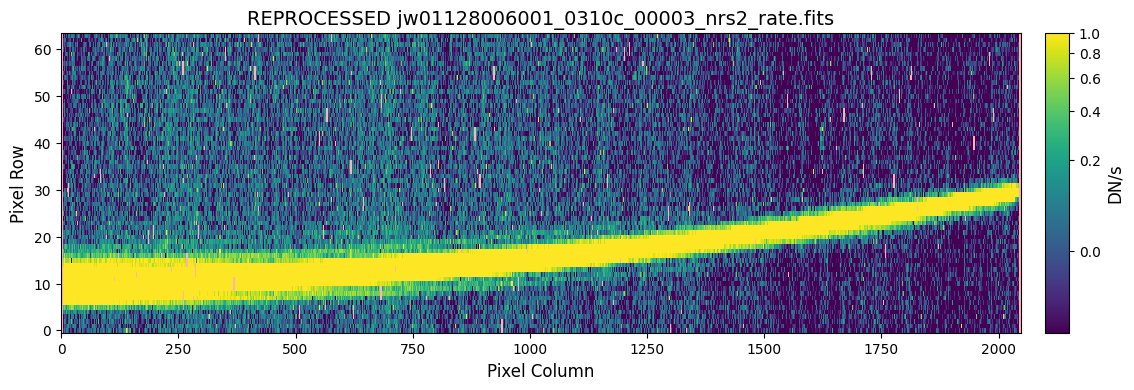

In [50]:
if doviz:
    rate_file = rate_sci[-1]  # Show the last rate file, as an example.
    display_rate(rate_file, vmin=-0.1, vmax=1, scale='asinh',
                 aspect=10, title_prefix='REPROCESSED')  # , extname='dq')

---

### 8.2 Display `Spec2Pipeline` Products

Inspect the Stage 2 calibrated spectra. Use Jdaviz [Specviz2D](https://jdaviz.readthedocs.io/en/stable/specviz2d/index.html) to visualize and analyze the Stage 2 2D and 1D calibrated spectra. For more information on these visualization tools and plotting capabilities, refer to the official documentation linked.

Unable to run Specviz2D, using matplotlib instead. ('no valid loaders found for input, tried', {'file': {'fits > 1D Spectrum': 'not valid', 'fits > 2D Spectrum': 'not valid', 'fits > 1D Spectrum List': "importer exception: 'PrimaryHDU' object has no attribute 'meta'", 'fits > 1D Spectrum Concatenated': "importer exception: 'PrimaryHDU' object has no attribute 'meta'", 'fits > Image': 'importer exception: list index out of range', 'fits > Subset': 'not valid', 'fits > Trace': 'not valid', 'fits > Catalog': 'not valid', 'jpgpng': 'not valid', 'asdf': 'not valid', 'Regions': 'not valid', 'specutils.Spectrum > 2D Spectrum': 'not valid', 'specutils.Spectrum > 1D Spectrum List': 'not valid', 'specutils.Spectrum > 1D Spectrum Concatenated': 'not valid', 'specutils.Spectrum > Image': 'importer exception: Cannot load as image with ndim=1', 'specutils.Spectrum > Subset': 'not valid', 'specutils.Spectrum > Trace': 'not valid', 'specutils.Spectrum > Catalog': 'not valid', 'specutils.SpectrumList':

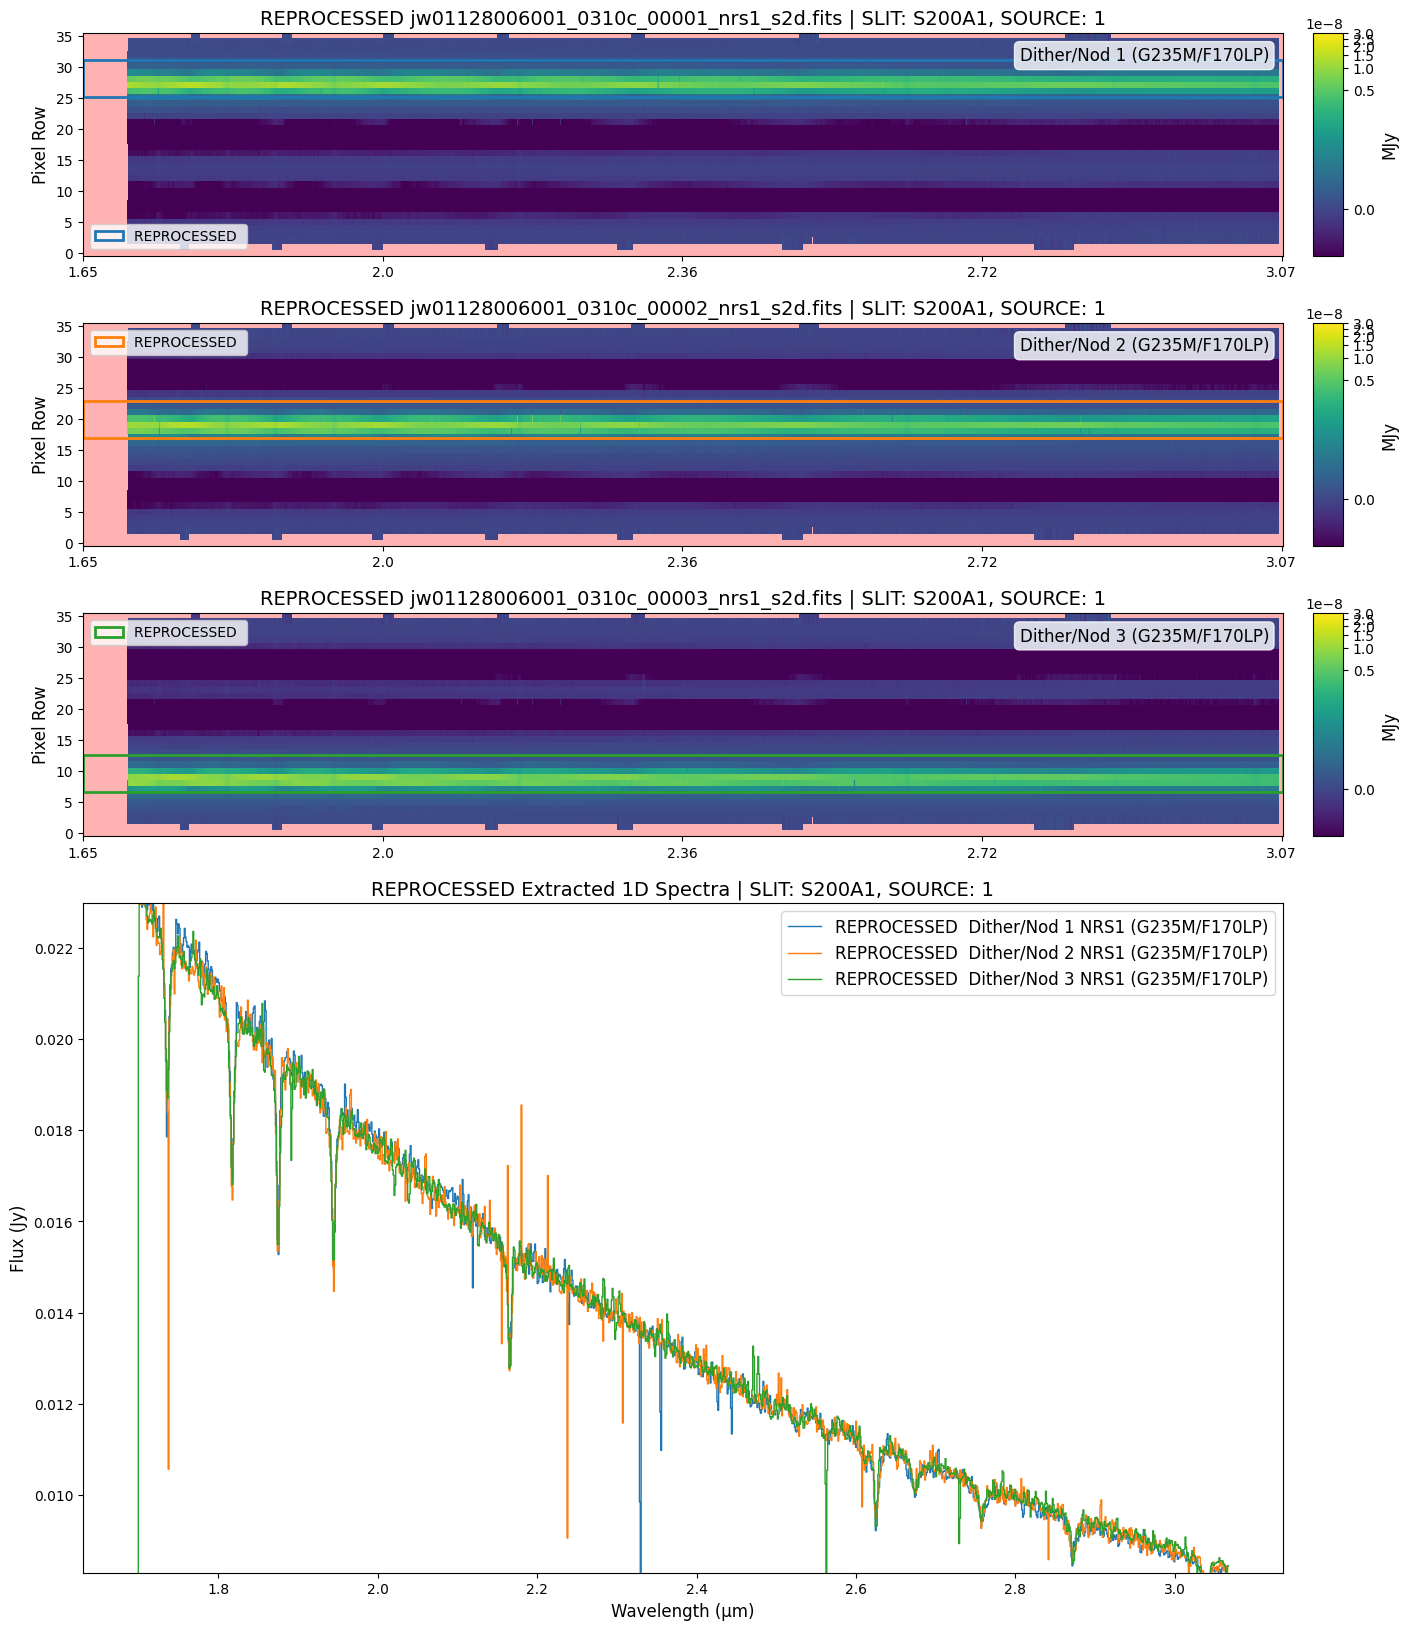

In [51]:
# Plot the Stage 2 FS spectra with Specviz2D.
if doviz:
    try:
        specviz2d = Specviz2d()
        spectrum_1d = sorted(glob.glob(spec2_dir + '*x1d.fits'))[1]
        spectrum_2d = sorted(glob.glob(spec2_dir + '*s2d.fits'))[1]
        specviz2d.load_data(spectrum_1d)
        specviz2d.show()
    except Exception as e:
        print(f"Unable to run Specviz2D, using matplotlib instead. {e}")
        display_spectra(sci_s2d + sci_x1d, source_id='S200A1', scale='log',
                        vmin=-0.1e-9, vmax=3e-8, title_prefix='REPROCESSED')

---

### 8.3 Display `Spec3Pipeline` Products

Inspect the Stage 3 combined calibrated spectra. 


In [52]:
# Plot the Stage 3 FS spectra with Specviz2D.
if doviz:
    try:
        specviz2d = Specviz2d()
        spectrum_1d = sorted(glob.glob(spec3_dir + '*x1d.fits'))[0]
        spectrum_2d = sorted(glob.glob(spec3_dir + '*s2d.fits'))[0]
        specviz2d.load_data(spectrum_2d=spectrum_2d, spectrum_1d=spectrum_1d)
        specviz2d.show()
    except ValueError:
        print("Unable to display spectra with Specviz2d")
        display_spectra(stage3_s2d + stage3_x1d, source_id='S200A1', scale='log',
                        vmin=-0.1e-9, vmax=3e-8, title_prefix='REPROCESSED', is_stage3=True)

Application(config='specviz2d', docs_link='https://jdaviz.readthedocs.io/en/v4.4.1/specviz2d/index.html', even…

---

## 9. Modifying the EXTRACT1D Reference File (as needed)

The `extract_1d` step's `use_source_pos` parameter in Stage 2 generally centers the 1D extraction box on the actual source location effectively and thus doesn't usually require manual adjustment. However, in some cases, adjusting the position of the extraction box by modifying the EXTRACT1D reference file may be useful. The following section demonstrates how to do this.

The EXTRACT1D reference file, along with several other parameter files, can be found in the `CRDS_PATH` directory. While some files, like `.json` files, can be manually edited, we modify them using Python.

<div class="alert alert-block alert-danger">
    
**Warning**: Currently, there is no aperture correction in place for NIRSpec, so the `extract_width` parameter **MUST** remain unchanged (6 pixels wide; 5 for S1600A1) to ensure proper flux calibration! The extraction box limits (`ystart` and `ystop`) can be modified; however, if `ystart` and `ystop` do not match the `extract_width`, the `extract_width` takes precedence and is applied symmetrically around the midpoint between `ystart` and `ystop`.

</div>


In [53]:
# Modify the EXTRACT1D reference file.

# If you don't know the reference file name this should work.
# extract_1d_ref = Spec3Pipeline().get_reference_file(stage3_s2d, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0008.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0008.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    yshift = -4  # Applied shift in pixels as example.

    # S200A1
    params["apertures"][0]["extract_width"] = 6
    params["apertures"][0]["ystart"] += yshift
    params["apertures"][0]["ystop"] += yshift

    # S200B1
    params["apertures"][1]["extract_width"] = 6
    params["apertures"][1]["ystart"] = 26.5
    params["apertures"][1]["ystop"] = 31.5

    # S200A2
    params["apertures"][2]["extract_width"] = 6
    params["apertures"][2]["ystart"] = 26.5
    params["apertures"][2]["ystop"] = 31.5

    # S400A1
    params["apertures"][3]["extract_width"] = 6
    params["apertures"][3]["ystart"] = 31
    params["apertures"][3]["ystop"] = 36

    # S1600A1
    params["apertures"][4]["extract_width"] = 5
    params["apertures"][4]["ystart"] = 14
    params["apertures"][4]["ystop"] = 18

# Write changes to a new file.
newData = json.dumps(params, indent=4)
# Add the suffix '_fs' to distinguish the file from the default version.
basename = os.path.basename(extract_1d_ref)[:-5]
extract_1d_ref_mod = os.path.join(basedir, basename + "_fs.json")
with open(extract_1d_ref_mod, "w") as file:
    file.write(newData)

In [54]:
# Inspect the EXTRACT1D reference file.
with open(extract_1d_ref_mod, 'r') as f_obj:
    extract_1d_ref_mod_data = json.load(f_obj)

JSON(extract_1d_ref_mod_data, expanded=True)

<IPython.core.display.JSON object>

Now, we re-extract the 1D spectrum by running the `Extract1dStep` and overriding the reference file.


In [55]:
Extract1dStep.call(stage3_s2d,
                   save_results=True,
                   output_dir=spec3_dir,
                   output_use_model=True,
                   suffix='x1d_mod',  # Change suffix to easily find modified file.
                   use_source_posn=False,
                   override_extract1d=extract_1d_ref_mod)

2025-11-10 19:28:38,639 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-11-10 19:28:38,961 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_s2d.fits'],).


2025-11-10 19:28:38,964 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_mod
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  extraction_type: box
  use_source_posn: False
  position_offset: 0.0
  model_nod_pair: True
  optimize_psf_location: True
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  save_residual_image: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: True
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None

2025-11-10 19:28:39,145 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/jwst_nirspec_extract1d_0008_fs.json


2025-11-10 19:28:39,148 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0003.fits


2025-11-10 19:28:39,182 - jwst.extract_1d.extract - INFO - Processing spectral order -1


2025-11-10 19:28:39,184 - jwst.extract_1d.extract - INFO - Aperture start/stop: 22.50 -> 27.50 (inclusive)


2025-11-10 19:28:39,188 - jwst.extract_1d.extract - INFO - Creating aperture correction.


2025-11-10 19:28:40,249 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 19:28:40,313 - stpipe.Extract1dStep - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/FSlit/fs_data_01128/Obs006/stage3/s200a1_f170lp_g235m_s200a1_s000000001_x1d_mod.fits


2025-11-10 19:28:40,314 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-11-10 19:28:40,314 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


<MultiSpecModel from s200a1_f170lp_g235m_s200a1_s000000001_x1d_mod.fits>

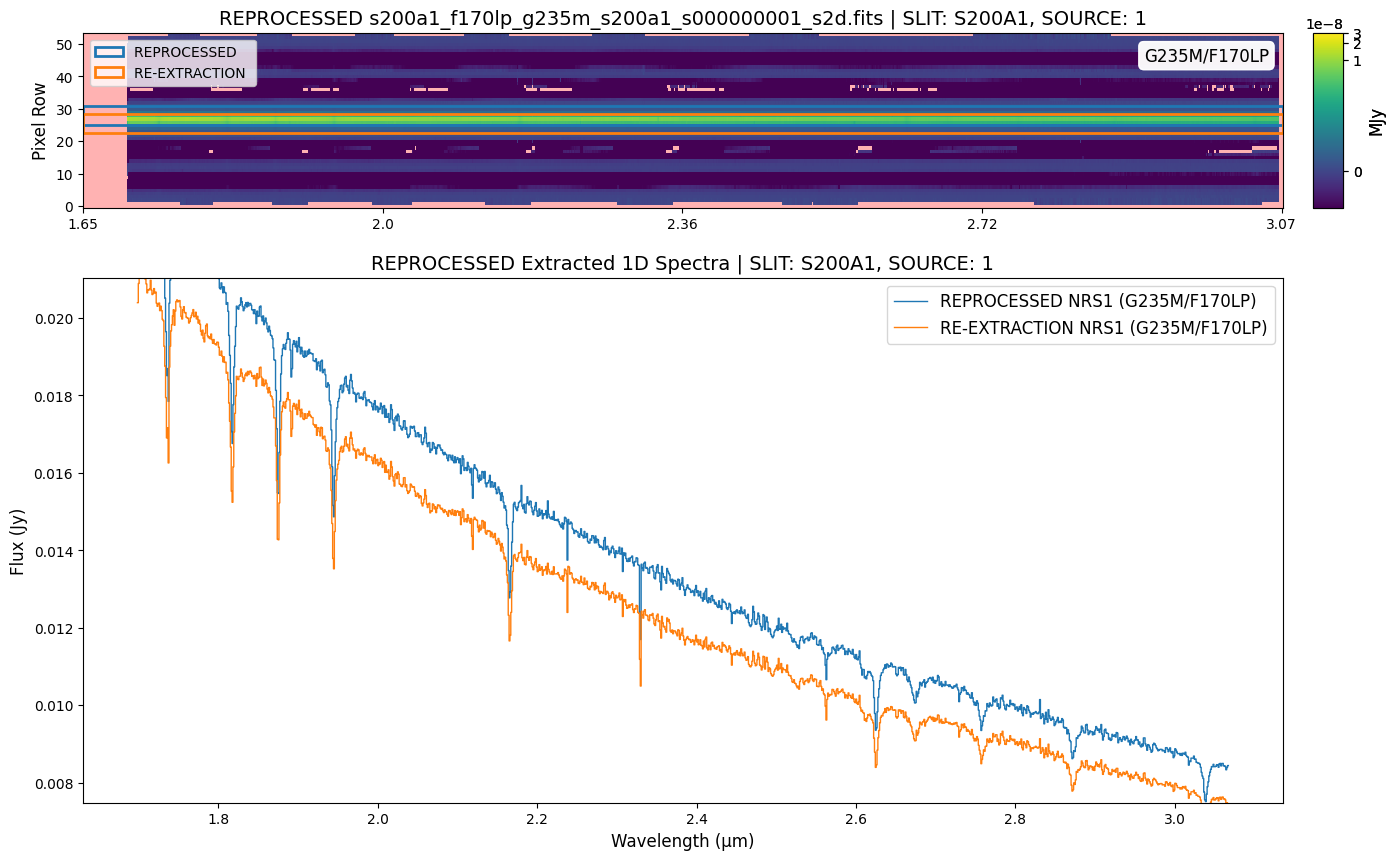

In [56]:
stage3_x1ds_mod = sorted(glob.glob(spec3_dir + '*_x1d_mod.fits'))
display_spectra(stage3_s2d + stage3_x1d, compare_x1d=stage3_x1ds_mod, source_id='S200A1',
                scale='log', vmin=-0.1e-9, vmax=3e-8,
                title_prefix='REPROCESSED', is_stage3=True)

As expected, the demo spectrum extracted in the shifted location has lower flux that the spectrum extracted in the center of the 2D spectral trace. 

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>
   
[Top of Page](#NIRSpec-FS-Pipeline-Notebook)